# Measuring all 5 protocols and 4 player sizes (720p+) (quality auto) on the test VM -- 1 video only

In [2]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
import Cdf
import Pmf
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()

In [3]:
conn = sqlite3.connect('../web-performance/web-performance-youtube-single-vm-5-proto.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements
#conn.close()

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error
0,e5f5130a-84cb-c651-f453-00b705527bbe,1645468238183222636,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:30:04.722114,auto,1280,720,0,30,aqz-KE-bpKQ,1,
1,8c5231a9-bc42-28d8-1dba-e0f25b423ca7,1645468273208159312,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:30:39.976429,auto,1280,720,0,30,aqz-KE-bpKQ,0,
2,715bcb78-35e4-41aa-d9b7-0384e0529b0d,1645468311162760538,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:31:17.708532,auto,1920,1080,0,30,aqz-KE-bpKQ,1,
3,c25cd82a-2a61-3909-cafb-f0d8c477bf5b,1645468346352580760,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:31:52.991132,auto,1920,1080,0,30,aqz-KE-bpKQ,0,
4,29d2303e-194c-8890-0671-5cc5ddb105a9,1645468384332457386,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:32:30.880862,auto,2560,1440,0,30,aqz-KE-bpKQ,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,3bf74cf9-67fc-9a51-b158-eaeff6b310f1,1645541527114580502,1.645542e+12,1.645541e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:51:33.848963,auto,1920,1080,0,30,aqz-KE-bpKQ,0,
1636,c7c8fde0-9300-a289-5338-22aaef8ca4f6,1645541566573279936,1.645542e+12,1.645542e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:52:13.110887,auto,2560,1440,0,30,aqz-KE-bpKQ,1,
1637,cadfe4d2-3431-2b82-dc74-5f3586f9d431,1645541602015247449,1.645542e+12,1.645542e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:52:48.432651,auto,2560,1440,0,30,aqz-KE-bpKQ,0,
1638,9334dcdd-8557-7d4c-1165-dc25648506ad,1645541639848938308,1.645542e+12,1.645542e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:53:26.506761,auto,3840,2160,0,30,aqz-KE-bpKQ,1,


# data pre-processing

In [4]:
measurements.error.unique()

array([''], dtype=object)

In [5]:
measurements['player_width'] = measurements['player_width'].astype(str)
measurements['player_height'] = measurements['player_height'].astype(str)
measurements['player_dimensions'] = measurements['player_width']+"x"+measurements['player_height']

In [6]:
measurements

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error,player_dimensions
0,e5f5130a-84cb-c651-f453-00b705527bbe,1645468238183222636,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:30:04.722114,auto,1280,720,0,30,aqz-KE-bpKQ,1,,1280x720
1,8c5231a9-bc42-28d8-1dba-e0f25b423ca7,1645468273208159312,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:30:39.976429,auto,1280,720,0,30,aqz-KE-bpKQ,0,,1280x720
2,715bcb78-35e4-41aa-d9b7-0384e0529b0d,1645468311162760538,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:31:17.708532,auto,1920,1080,0,30,aqz-KE-bpKQ,1,,1920x1080
3,c25cd82a-2a61-3909-cafb-f0d8c477bf5b,1645468346352580760,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:31:52.991132,auto,1920,1080,0,30,aqz-KE-bpKQ,0,,1920x1080
4,29d2303e-194c-8890-0671-5cc5ddb105a9,1645468384332457386,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:32:30.880862,auto,2560,1440,0,30,aqz-KE-bpKQ,1,,2560x1440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,3bf74cf9-67fc-9a51-b158-eaeff6b310f1,1645541527114580502,1.645542e+12,1.645541e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:51:33.848963,auto,1920,1080,0,30,aqz-KE-bpKQ,0,,1920x1080
1636,c7c8fde0-9300-a289-5338-22aaef8ca4f6,1645541566573279936,1.645542e+12,1.645542e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:52:13.110887,auto,2560,1440,0,30,aqz-KE-bpKQ,1,,2560x1440
1637,cadfe4d2-3431-2b82-dc74-5f3586f9d431,1645541602015247449,1.645542e+12,1.645542e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:52:48.432651,auto,2560,1440,0,30,aqz-KE-bpKQ,0,,2560x1440
1638,9334dcdd-8557-7d4c-1165-dc25648506ad,1645541639848938308,1.645542e+12,1.645542e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:53:26.506761,auto,3840,2160,0,30,aqz-KE-bpKQ,1,,3840x2160


## find the optimal resolution as determined by the youtube player for each run

In [7]:
df_optimal_resolutions = pd.read_sql_query("""
SELECT DISTINCT msm_id, resolution, time FROM nerd_stats
""", conn)

In [8]:
df_optimal_resolutions['current_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[0]
df_optimal_resolutions['current_res'] = df_optimal_resolutions['current_res'].str.split('@').str[0]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[1]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['optimal_res'].str.split('@').str[0]
df_optimal_resolutions['time'] = pd.to_datetime(df_optimal_resolutions['time'], unit='ms', origin='unix')

In [9]:
df_optimal_resolutions = df_optimal_resolutions[['msm_id','optimal_res', 'time', 'current_res']]

In [10]:
df_optimal_resolutions.groupby('msm_id').optimal_res.nunique().sort_values()

msm_id
004b1e9e-6df8-f59d-ae6a-2da91ad17d7c    1
b0540d2a-a4a5-8ec5-19ea-c9d64fe4ab93    1
b036fb6f-62b4-ab15-e1ee-2b25b38acaac    1
aff3eef0-fc57-5583-c730-ff531bc3a884    1
afec3644-ee1f-545d-1fc2-ff45421ebd14    1
                                       ..
491aa013-5323-1fab-7ac7-69f8fd3d8760    2
5c56630d-ba70-1f4b-84af-ed480416bb88    2
40506e66-0285-2d47-8142-e07d60e12065    2
9377e896-b27e-ecd7-0171-e6f36be579d1    2
ba581ef5-c9a1-39f0-8d13-39091bfbfae9    2
Name: optimal_res, Length: 1640, dtype: int64

### filter out measurements where the player changes the optimal resolution within the run (mostly from 4k to 1440p)

In [11]:
s_filter_msm = df_optimal_resolutions.groupby('msm_id').optimal_res.nunique()

In [12]:
s_filter_msm[s_filter_msm > 1].index.tolist()

['40506e66-0285-2d47-8142-e07d60e12065',
 '491aa013-5323-1fab-7ac7-69f8fd3d8760',
 '5c56630d-ba70-1f4b-84af-ed480416bb88',
 '9377e896-b27e-ecd7-0171-e6f36be579d1',
 'ba581ef5-c9a1-39f0-8d13-39091bfbfae9']

In [13]:
df_optimal_resolutions[df_optimal_resolutions.msm_id.isin(s_filter_msm[s_filter_msm > 1].index.tolist())].sort_values('time').groupby(['msm_id', 'optimal_res']).agg({'time':'min'}).sort_values('time')

time
msm_id                               optimal_res                              
9377e896-b27e-ecd7-0171-e6f36be579d1 3840x2160   2022-02-21 20:49:16.884100096
                                     2560x1440   2022-02-21 20:49:34.595300096
40506e66-0285-2d47-8142-e07d60e12065 3840x2160   2022-02-21 23:19:10.119800064
                                     2560x1440   2022-02-21 23:19:40.011599872
5c56630d-ba70-1f4b-84af-ed480416bb88 3840x2160   2022-02-22 06:13:38.568499968
                                     2560x1440   2022-02-22 06:14:04.034800128
491aa013-5323-1fab-7ac7-69f8fd3d8760 3840x2160   2022-02-22 11:38:44.539200000
                                     2560x1440   2022-02-22 11:39:04.265099776
ba581ef5-c9a1-39f0-8d13-39091bfbfae9 3840x2160   2022-02-22 11:49:09.017999872
                                     2560x1440   2022-02-22 11:49:26.622700032

first idea: we take the nerd stats optimal res at the end of playback (i.e. the furthest in terms of video playback) as the "true" optimal res  ------ probably dumb idea, see example above, for now just filter out the ones with multiple optimal resolutions?

In [14]:
#assert set(df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.value_counts().values) == {1}
#assert df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.nunique() == measurements.msm_id.nunique()
#df_optimal_resolutions = df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].reset_index(drop=True)


In [15]:
df_msms_with_multiple_opt_res = df_optimal_resolutions.groupby('msm_id', as_index=False).agg(opt_res_num=('optimal_res',pd.Series.nunique), opt_res_list=('optimal_res',pd.Series.unique)).sort_values('opt_res_num')

In [16]:
df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1]

,msm_id,opt_res_num,opt_res_list
437,491aa013-5323-1fab-7ac7-69f8fd3d8760,2,"[3840x2160, 2560x1440]"
549,5c56630d-ba70-1f4b-84af-ed480416bb88,2,"[3840x2160, 2560x1440]"
375,40506e66-0285-2d47-8142-e07d60e12065,2,"[3840x2160, 2560x1440]"
895,9377e896-b27e-ecd7-0171-e6f36be579d1,2,"[3840x2160, 2560x1440]"
1162,ba581ef5-c9a1-39f0-8d13-39091bfbfae9,2,"[3840x2160, 2560x1440]"


In [17]:
measurements_to_remove = df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1].msm_id.unique().tolist()

In [18]:
measurements_to_remove

['491aa013-5323-1fab-7ac7-69f8fd3d8760',
 '5c56630d-ba70-1f4b-84af-ed480416bb88',
 '40506e66-0285-2d47-8142-e07d60e12065',
 '9377e896-b27e-ecd7-0171-e6f36be579d1',
 'ba581ef5-c9a1-39f0-8d13-39091bfbfae9']

In [19]:
measurements[measurements.msm_id.isin(measurements_to_remove)].player_dimensions.value_counts()

3840x2160    5
Name: player_dimensions, dtype: int64

In [20]:
measurements[measurements.msm_id.isin(measurements_to_remove)].protocol.value_counts()

tcp      3
https    1
quic     1
Name: protocol, dtype: int64

In [21]:
measurements[measurements.player_dimensions == "3840x2160"].protocol.value_counts()

quic     82
tcp      82
udp      82
tls      82
https    82
Name: protocol, dtype: int64

In [22]:
df_optimal_resolutions = df_optimal_resolutions[~df_optimal_resolutions.msm_id.isin(measurements_to_remove)][['msm_id', 'optimal_res']].drop_duplicates().reset_index().drop('index', axis=1)

In [23]:
df_optimal_resolutions

,msm_id,optimal_res
0,e5f5130a-84cb-c651-f453-00b705527bbe,1280x720
1,8c5231a9-bc42-28d8-1dba-e0f25b423ca7,1280x720
2,715bcb78-35e4-41aa-d9b7-0384e0529b0d,1920x1080
3,c25cd82a-2a61-3909-cafb-f0d8c477bf5b,1920x1080
4,29d2303e-194c-8890-0671-5cc5ddb105a9,2560x1440
...,...,...
1630,3bf74cf9-67fc-9a51-b158-eaeff6b310f1,1920x1080
1631,c7c8fde0-9300-a289-5338-22aaef8ca4f6,2560x1440
1632,cadfe4d2-3431-2b82-dc74-5f3586f9d431,2560x1440
1633,9334dcdd-8557-7d4c-1165-dc25648506ad,3840x2160


In [24]:
df_optimal_resolutions = pd.merge(df_optimal_resolutions, measurements[['msm_id', 'player_dimensions']], on='msm_id')
df_optimal_resolutions

,msm_id,optimal_res,player_dimensions
0,e5f5130a-84cb-c651-f453-00b705527bbe,1280x720,1280x720
1,8c5231a9-bc42-28d8-1dba-e0f25b423ca7,1280x720,1280x720
2,715bcb78-35e4-41aa-d9b7-0384e0529b0d,1920x1080,1920x1080
3,c25cd82a-2a61-3909-cafb-f0d8c477bf5b,1920x1080,1920x1080
4,29d2303e-194c-8890-0671-5cc5ddb105a9,2560x1440,2560x1440
...,...,...,...
1630,3bf74cf9-67fc-9a51-b158-eaeff6b310f1,1920x1080,1920x1080
1631,c7c8fde0-9300-a289-5338-22aaef8ca4f6,2560x1440,2560x1440
1632,cadfe4d2-3431-2b82-dc74-5f3586f9d431,2560x1440,2560x1440
1633,9334dcdd-8557-7d4c-1165-dc25648506ad,3840x2160,3840x2160


### make sure the optimal resolutions match what we set as the player size

In [25]:
df_optimal_resolutions[df_optimal_resolutions.optimal_res != df_optimal_resolutions.player_dimensions]

,msm_id,optimal_res,player_dimensions


### make sure each run has a start playing event that fired before 1s of playtime passed (there seems to always be a little bit of playtime (i.e. the curr play time when the event fires is never zero) presumably due to the delay from javascript execution between getting the playback time within the callback)

In [26]:
df_player_state_playing = pd.read_sql_query("select * from iframe_api where event_type = 'PlayerStatePLAYING'", conn)

In [27]:
df_player_state_playing[df_player_state_playing.curr_play_time > 1].curr_play_time.describe()

count    1281.000000
mean       19.835568
std         2.422509
min         3.117650
25%        17.943333
50%        19.350333
75%        21.121000
max        28.246888
Name: curr_play_time, dtype: float64

In [28]:
df_player_state_playing[df_player_state_playing.curr_play_time < 1].curr_play_time.describe()

count    1640.000000
mean        0.022259
std         0.013087
min         0.005912
25%         0.016744
50%         0.020574
75%         0.023684
max         0.182509
Name: curr_play_time, dtype: float64

In [29]:
df_player_state_intial_playback = df_player_state_playing[df_player_state_playing.curr_play_time < 1]

make sure each measurement only has one corresponding initial playing state event and that all measurements have such an event

In [30]:
assert set(df_player_state_intial_playback.msm_id.value_counts().values) == {1}
assert pd.Series.nunique(df_player_state_intial_playback.msm_id.value_counts().index) == \
pd.Series.nunique(measurements['msm_id'])

### if the 1s metric produced a unique start playing state event for each run, we can use it to calculate the startup delay between when we tell the player to start playing and when it actually plays

In [31]:
df_start_time = pd.read_sql_query("""
SELECT start_time, play_time, msm_id, current_quality AS initial_quality FROM
(SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction')
JOIN
(SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1)
USING (msm_id);
""", conn)

df_start_time['start_time'] = pd.to_datetime(df_start_time['start_time'], unit='ms', origin='unix')
df_start_time['play_time'] = pd.to_datetime(df_start_time['play_time'], unit='ms', origin='unix')

df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [32]:
df_start_time

,start_time,play_time,msm_id,initial_quality,startup_delay
0,2022-02-21 18:30:07.198200320,2022-02-21 18:30:07.606900224,e5f5130a-84cb-c651-f453-00b705527bbe,hd720,0.4087
1,2022-02-21 18:30:42.292100096,2022-02-21 18:30:42.688600064,8c5231a9-bc42-28d8-1dba-e0f25b423ca7,hd720,0.3965
2,2022-02-21 18:31:20.092999936,2022-02-21 18:31:20.515099904,715bcb78-35e4-41aa-d9b7-0384e0529b0d,hd1080,0.4221
3,2022-02-21 18:31:55.329699840,2022-02-21 18:31:55.718899968,c25cd82a-2a61-3909-cafb-f0d8c477bf5b,hd1080,0.3892
4,2022-02-21 18:32:33.244900096,2022-02-21 18:32:33.716000000,29d2303e-194c-8890-0671-5cc5ddb105a9,hd1440,0.4711
...,...,...,...,...,...
1635,2022-02-22 14:51:36.126299904,2022-02-22 14:51:36.513299712,3bf74cf9-67fc-9a51-b158-eaeff6b310f1,hd1080,0.3870
1636,2022-02-22 14:52:15.426099968,2022-02-22 14:52:15.895500032,c7c8fde0-9300-a289-5338-22aaef8ca4f6,medium,0.4694
1637,2022-02-22 14:52:50.845499904,2022-02-22 14:52:51.329499904,cadfe4d2-3431-2b82-dc74-5f3586f9d431,hd1440,0.4840
1638,2022-02-22 14:53:28.833699840,2022-02-22 14:53:29.210299904,9334dcdd-8557-7d4c-1165-dc25648506ad,hd2160,0.3766


### for each measurement we call getQuality when the player fires the start playing callback, however this seems to again be susceptible to some delay, some measurements have quality change events for that resolution fire __after__ the recorded timestamp for the playing event ---> thus we figure out the quality change event that happened closest to the timestamp of the start playing event but still happened before it

In [33]:
df_player_quality_change_event = pd.read_sql_query("select * from iframe_api where event_type LIKE 'QualityChange%'", conn)

In [34]:
df_player_quality_change_event['time'] = pd.to_datetime(df_player_quality_change_event['time'], unit='ms', origin='unix')

In [35]:
df_player_quality_change_event.curr_play_time.value_counts().sort_index()

0.000000     3255
0.020352        1
0.023780        1
0.025229        1
0.027003        1
             ... 
27.618637       1
27.627170       1
27.793674       1
27.848506       1
27.866526       1
Name: curr_play_time, Length: 244, dtype: int64

In [36]:
df_player_quality_change_event[df_player_quality_change_event.curr_play_time == 0].msm_id.value_counts()

b5ad57e1-178c-0685-6db4-e1f6079a6fd5    3
f4e4f7bf-d1a1-0f22-333a-6fe4b09fd164    3
4e8a315c-198a-94c1-52d5-12e889b480fd    3
6ffa763e-21f0-a67f-9c35-b0b64977df16    2
83c907cb-9454-86f4-179f-e7b872cf8889    2
                                       ..
e3969b54-0d2d-ee4c-9c03-aa2f9eeb9dad    1
e604952d-fd12-2405-b8fb-f6ed65c56575    1
d8d509fe-33f7-953b-7cfa-341d0f0ef548    1
4d11c43c-b285-1a99-88e6-5e14af3e69bf    1
9dad86c2-315d-3658-140c-70af87474b26    1
Name: msm_id, Length: 1640, dtype: int64

In [37]:
df_player_quality_change_event[df_player_quality_change_event.msm_id == "b5ad57e1-178c-0685-6db4-e1f6079a6fd5"]

,time,event_type,buffer_perc,curr_play_time,video_dur,current_quality,available_qualities,msm_id
3053,2022-02-22 12:17:17.272499968,QualityChangeMedium,0.0,0.0,-1.0,medium,-1,b5ad57e1-178c-0685-6db4-e1f6079a6fd5
3054,2022-02-22 12:17:17.396000000,QualityChange1080,0.0,0.0,-1.0,hd1080,-1,b5ad57e1-178c-0685-6db4-e1f6079a6fd5
3055,2022-02-22 12:17:17.541600000,QualityChange1440,0.0,0.0,-1.0,hd1440,-1,b5ad57e1-178c-0685-6db4-e1f6079a6fd5


In [38]:
measurements[measurements.msm_id == "b5ad57e1-178c-0685-6db4-e1f6079a6fd5"]

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error,player_dimensions
1428,b5ad57e1-178c-0685-6db4-e1f6079a6fd5,1645532268169474845,1.645532e+12,1.645532e+12,tcp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 12:17:14.734803,auto,2560,1440,0,30,aqz-KE-bpKQ,1,,2560x1440


In [39]:
df_start_time[df_start_time.msm_id == "b5ad57e1-178c-0685-6db4-e1f6079a6fd5"]

,start_time,play_time,msm_id,initial_quality,startup_delay
1428,2022-02-22 12:17:17.054700288,2022-02-22 12:17:17.592800,b5ad57e1-178c-0685-6db4-e1f6079a6fd5,hd1440,0.5381


In [40]:
df_true_initial_quality = pd.merge(df_start_time[['msm_id', 'play_time', 'initial_quality']], df_player_quality_change_event[df_player_quality_change_event.curr_play_time < 1][['time', 'current_quality', 'msm_id']], on='msm_id')


In [41]:
df_true_initial_quality['delay_to_play_time'] = (df_true_initial_quality['play_time'] - df_true_initial_quality['time']).dt.total_seconds()

In [42]:
df_true_initial_quality[df_true_initial_quality.msm_id == "d73665d4-0fb1-b7da-a218-6016e229c4aa"]

,msm_id,play_time,initial_quality,time,current_quality,delay_to_play_time
2649,d73665d4-0fb1-b7da-a218-6016e229c4aa,2022-02-22 10:44:13.367599872,hd1440,2022-02-22 10:44:13.262099968,medium,0.1055
2650,d73665d4-0fb1-b7da-a218-6016e229c4aa,2022-02-22 10:44:13.367599872,hd1440,2022-02-22 10:44:13.368699904,hd1440,-0.0011
2651,d73665d4-0fb1-b7da-a218-6016e229c4aa,2022-02-22 10:44:13.367599872,hd1440,2022-02-22 10:44:13.791000064,hd2160,-0.4234


In [43]:
df_true_initial_quality = df_true_initial_quality[df_true_initial_quality.delay_to_play_time > 0]

In [44]:
df_true_initial_quality = df_true_initial_quality.loc[df_true_initial_quality.groupby('msm_id').delay_to_play_time.idxmin()].reset_index(drop=True)

In [45]:
df_true_initial_quality[df_true_initial_quality.initial_quality != df_true_initial_quality.current_quality]

,msm_id,play_time,initial_quality,time,current_quality,delay_to_play_time
193,20ab961e-6a51-d5e1-9a20-e3b14a0dd445,2022-02-21 22:33:48.694700288,hd2160,2022-02-21 22:33:48.477299968,medium,0.2174
462,4d11c43c-b285-1a99-88e6-5e14af3e69bf,2022-02-22 12:45:25.146200064,hd720,2022-02-22 12:45:25.026300160,medium,0.1199
1317,d04ef1c4-c2e2-de8e-5d77-4d9111f5e9ae,2022-02-22 05:05:03.074099968,hd720,2022-02-22 05:05:02.751899904,medium,0.3222
1359,d73665d4-0fb1-b7da-a218-6016e229c4aa,2022-02-22 10:44:13.367599872,hd1440,2022-02-22 10:44:13.262099968,medium,0.1055
1375,d8d509fe-33f7-953b-7cfa-341d0f0ef548,2022-02-21 21:50:24.768099840,hd720,2022-02-21 21:50:24.626500096,medium,0.1416
1448,e3969b54-0d2d-ee4c-9c03-aa2f9eeb9dad,2022-02-22 01:13:38.630000128,hd2160,2022-02-22 01:13:38.492700160,medium,0.1373


In [46]:
df_true_initial_quality.rename(columns=lambda x: x.replace('current_quality', 'true_initial_quality'), inplace=True)

In [47]:
df_true_initial_quality

,msm_id,play_time,initial_quality,time,true_initial_quality,delay_to_play_time
0,004b1e9e-6df8-f59d-ae6a-2da91ad17d7c,2022-02-22 07:01:21.332899840,hd1080,2022-02-22 07:01:21.206500096,hd1080,0.1264
1,0081e09c-14dd-636b-7319-b33568945398,2022-02-22 04:39:57.323100160,hd720,2022-02-22 04:39:57.309299968,hd720,0.0138
2,009b8f78-707f-4b43-40fb-b30220b90392,2022-02-21 21:38:45.217299712,hd2160,2022-02-21 21:38:45.103000064,hd2160,0.1143
3,00f82005-2a8a-e240-8075-d3a7e6b7740e,2022-02-22 13:47:58.191399936,hd1440,2022-02-22 13:47:58.180999936,hd1440,0.0104
4,011f18fb-41e5-3d5c-3666-b7c991f6130d,2022-02-22 07:33:47.844600064,hd2160,2022-02-22 07:33:47.808600064,hd2160,0.0360
...,...,...,...,...,...,...
1635,ff2e8d05-b4e7-52c5-b3fe-d7c4c5867146,2022-02-22 07:45:26.833199872,hd720,2022-02-22 07:45:26.817499904,hd720,0.0157
1636,ff334cb3-4faf-47ff-6a8d-dc69059742c8,2022-02-22 10:01:21.299600128,hd1080,2022-02-22 10:01:21.226800128,hd1080,0.0728
1637,ff4c7009-6281-7631-f703-3610539ae1e9,2022-02-22 11:40:33.524300032,hd720,2022-02-22 11:40:33.443700224,hd720,0.0806
1638,ffa58823-bc29-98e8-b823-3cb560953e65,2022-02-21 19:21:38.596400128,hd1080,2022-02-21 19:21:38.476199936,hd1080,0.1202


### helper functions

In [48]:
res_to_quality = {
    "256x144":"tiny", "426x240": "small", "640x360": "medium", "854x480": "large",
    "1280x720": "hd720", "1920x1080": "hd1080", "2560x1440": "hd1440", "3840x2160": "hd2160"
}

quality_to_res = {v: k for k, v in res_to_quality.items()}

def map_quality_to_res(quality):
    return quality_to_res[quality]
def map_res_to_quality(resolution):
    return res_to_quality[resolution]

def make_quality_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['auto', 'tiny', 'small', 'medium', 'large', 'hd720', 'hd1080', 'highres', 'hd1440', 'hd2160'])

def make_res_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['256x144', '426x240', '640x360', '854x480', '1280x720', '1920x1080', '2560x1440', '3840x2160'])

In [49]:
df_resource_timing = pd.read_sql_query("SELECT * FROM page_resources", conn)

In [50]:
df_resource_timing['googlevideo'] = df_resource_timing.name.str.split('/').str[2]

In [51]:
df_resource_timing.googlevideo.unique()

array(['rr2---sn-4g5ednly.googlevideo.com',
       'rr2---sn-4g5lzner.googlevideo.com',
       'rr1---sn-1gieen7e.googlevideo.com'], dtype=object)

In [52]:
df_resource_timing.msm_id.nunique()

1640

In [53]:
df_resource_timing = pd.merge(df_resource_timing, measurements[['msm_id', 'cacheWarming', 'player_dimensions']])

In [54]:
df_resource_timing.groupby(['player_dimensions', 'googlevideo']).agg({'cacheWarming':lambda x: list(set(x))})

cacheWarming
player_dimensions googlevideo                                   
1280x720          rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
1920x1080         rr1---sn-1gieen7e.googlevideo.com       [0, 1]
                  rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
2560x1440         rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
3840x2160         rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]

In [55]:
df_start_time = df_start_time[~df_start_time.msm_id.isin(measurements_to_remove)]

In [56]:
measurements

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error,player_dimensions
0,e5f5130a-84cb-c651-f453-00b705527bbe,1645468238183222636,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:30:04.722114,auto,1280,720,0,30,aqz-KE-bpKQ,1,,1280x720
1,8c5231a9-bc42-28d8-1dba-e0f25b423ca7,1645468273208159312,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:30:39.976429,auto,1280,720,0,30,aqz-KE-bpKQ,0,,1280x720
2,715bcb78-35e4-41aa-d9b7-0384e0529b0d,1645468311162760538,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:31:17.708532,auto,1920,1080,0,30,aqz-KE-bpKQ,1,,1920x1080
3,c25cd82a-2a61-3909-cafb-f0d8c477bf5b,1645468346352580760,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:31:52.991132,auto,1920,1080,0,30,aqz-KE-bpKQ,0,,1920x1080
4,29d2303e-194c-8890-0671-5cc5ddb105a9,1645468384332457386,1.645468e+12,1.645468e+12,tls,94.140.14.140,aqz-KE-bpKQ,,2022-02-21 18:32:30.880862,auto,2560,1440,0,30,aqz-KE-bpKQ,1,,2560x1440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,3bf74cf9-67fc-9a51-b158-eaeff6b310f1,1645541527114580502,1.645542e+12,1.645541e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:51:33.848963,auto,1920,1080,0,30,aqz-KE-bpKQ,0,,1920x1080
1636,c7c8fde0-9300-a289-5338-22aaef8ca4f6,1645541566573279936,1.645542e+12,1.645542e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:52:13.110887,auto,2560,1440,0,30,aqz-KE-bpKQ,1,,2560x1440
1637,cadfe4d2-3431-2b82-dc74-5f3586f9d431,1645541602015247449,1.645542e+12,1.645542e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:52:48.432651,auto,2560,1440,0,30,aqz-KE-bpKQ,0,,2560x1440
1638,9334dcdd-8557-7d4c-1165-dc25648506ad,1645541639848938308,1.645542e+12,1.645542e+12,udp,94.140.14.140,aqz-KE-bpKQ,,2022-02-22 14:53:26.506761,auto,3840,2160,0,30,aqz-KE-bpKQ,1,,3840x2160


In [57]:
df_start_time = pd.merge(df_start_time, measurements[['msm_id', 'cacheWarming', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']])

In [58]:
df_start_time = df_start_time[df_start_time.cacheWarming == 0]

In [59]:
df_start_time.protocol.value_counts()

udp      164
https    164
quic     164
tls      164
tcp      161
Name: protocol, dtype: int64

In [60]:
df_start_time.columns

Index(['start_time', 'play_time', 'msm_id', 'initial_quality', 'startup_delay',
       'cacheWarming', 'player_dimensions', 'protocol', 'vantagePoint',
       'domain'],
      dtype='object')

In [61]:
df_start_time = pd.merge(df_start_time, df_true_initial_quality[['msm_id', 'true_initial_quality']], on='msm_id')

In [62]:
df_start_time[df_start_time.initial_quality != df_start_time.true_initial_quality]

,start_time,play_time,msm_id,initial_quality,startup_delay,cacheWarming,player_dimensions,protocol,vantagePoint,domain,true_initial_quality
135,2022-02-21 21:50:24.404099840,2022-02-21 21:50:24.768099840,d8d509fe-33f7-953b-7cfa-341d0f0ef548,hd720,0.3640,0,1280x720,udp,,aqz-KE-bpKQ,medium
649,2022-02-22 10:44:12.994500096,2022-02-22 10:44:13.367599872,d73665d4-0fb1-b7da-a218-6016e229c4aa,hd1440,0.3731,0,3840x2160,quic,,aqz-KE-bpKQ,medium
729,2022-02-22 12:45:24.786200064,2022-02-22 12:45:25.146200064,4d11c43c-b285-1a99-88e6-5e14af3e69bf,hd720,0.3600,0,1280x720,tcp,,aqz-KE-bpKQ,medium


In [63]:
make_quality_column_sortable(df_start_time, 'true_initial_quality')
make_quality_column_sortable(df_start_time, 'initial_quality')
make_res_column_sortable(df_start_time, 'player_dimensions')

In [72]:
def draw_cdf(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim):
    colors = dict(zip(list(df_[col_name_].unique()), ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(list(df_[col_name_].unique()), ['o','v','^','>','s','p','h','d','<','.']))
    for vp in df_['vantagePoint'].unique():
        print(vp)
        for video in df_['domain'].unique():
            for log in log_list:
                for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                    lnwidth = .5
                    mrksize = 3
                    df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                    fig, ax = plt.subplots(figsize=(5,2))
                    for col_val_ in df_tmp[col_name_].sort_values().unique():
                        cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                    linestyle='-', linewidth=lnwidth, 
                                    markersize=mrksize, fillstyle='none', 
                                    markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                    color=colors[col_val_], marker=markers[col_val_]
                                )
                        #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                    ax.spines['right'].set_color('none')
                    ax.spines['top'].set_color('none')
                    ax.yaxis.set_ticks_position('left')
                    ax.xaxis.set_ticks_position('bottom')
                    ax.spines['bottom'].set_position(('axes', -0.0))
                    ax.spines['left'].set_position(('axes', -0.0))

                    if not log:
                        #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                        ax.legend(loc='lower right', ncol=3, markerscale=2)
                    else:
                        ax.set_xscale('log')
                        #ax.set_xscale('symlog')
                        ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.5))

                    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


                    ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                    ax.set_xlabel(xlabel)

                    ax.set_ylabel("CDF")
                    if xlim != [0,0]:
                        ax.set_xlim(xlim)
                        
                    for line in ax.get_legend().get_lines():
                        line.set_linewidth(2.0)

                    if log:
                        fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                    else:
                        fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                    plt.show()

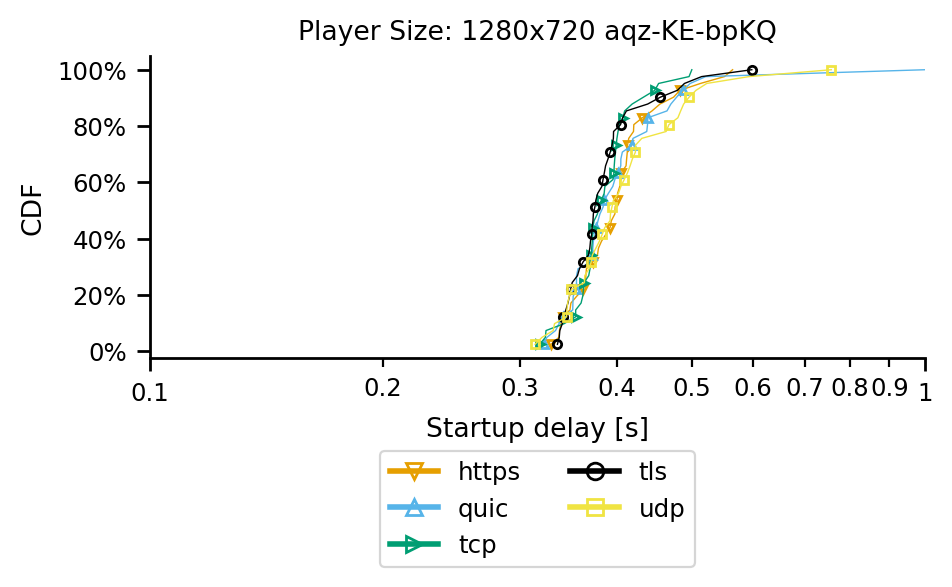

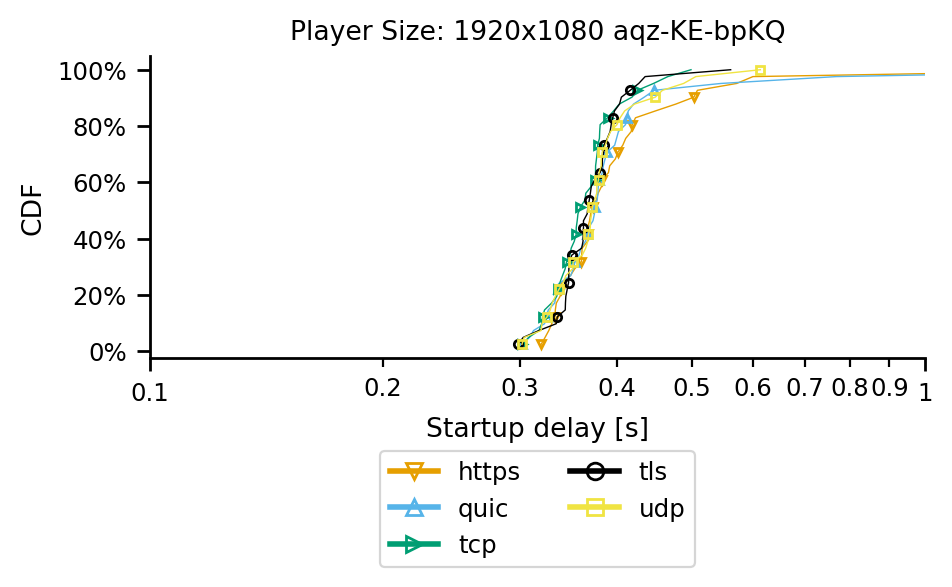

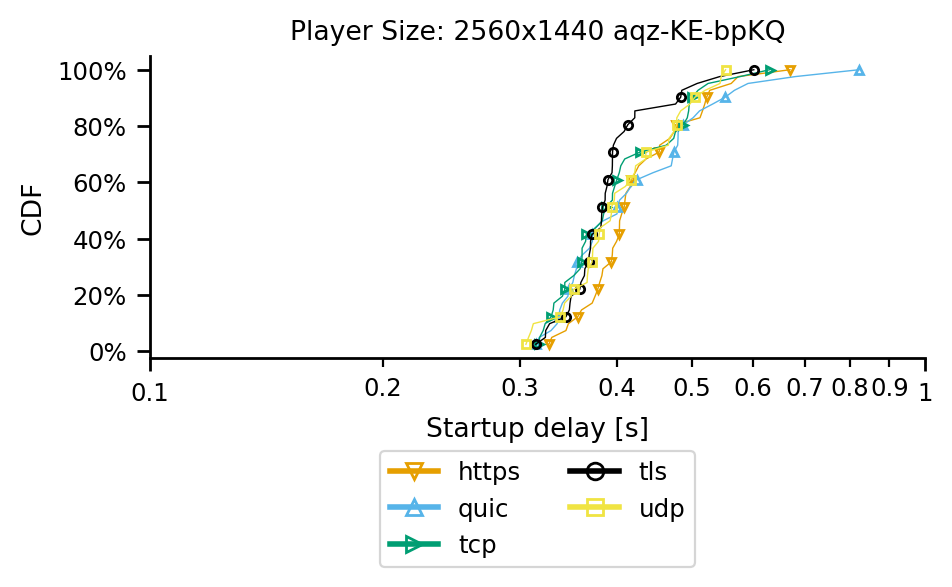

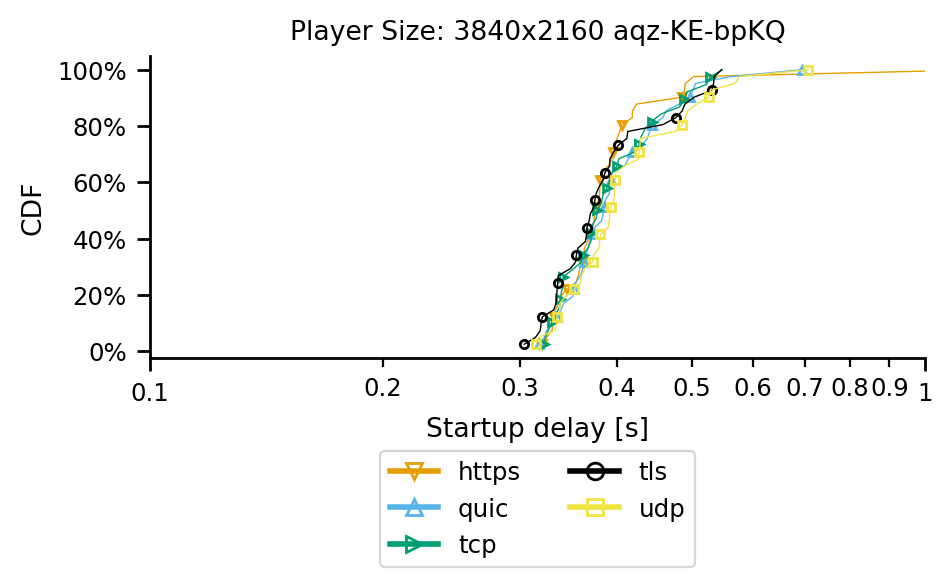

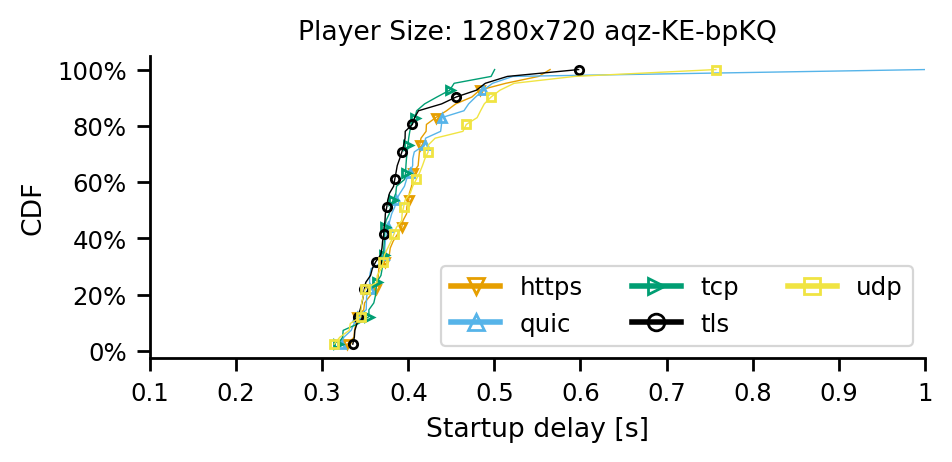

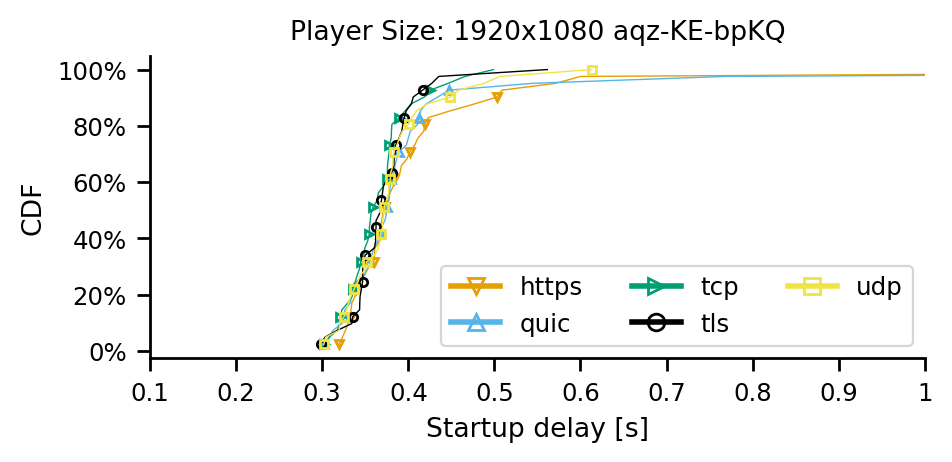

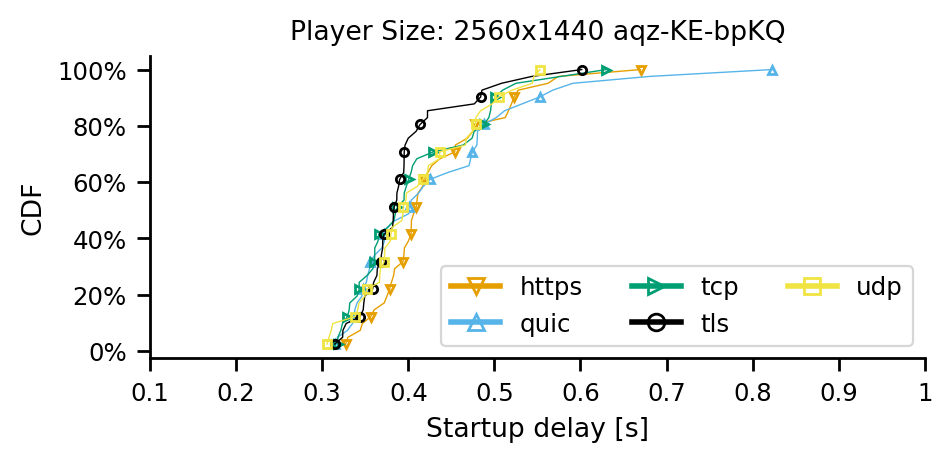

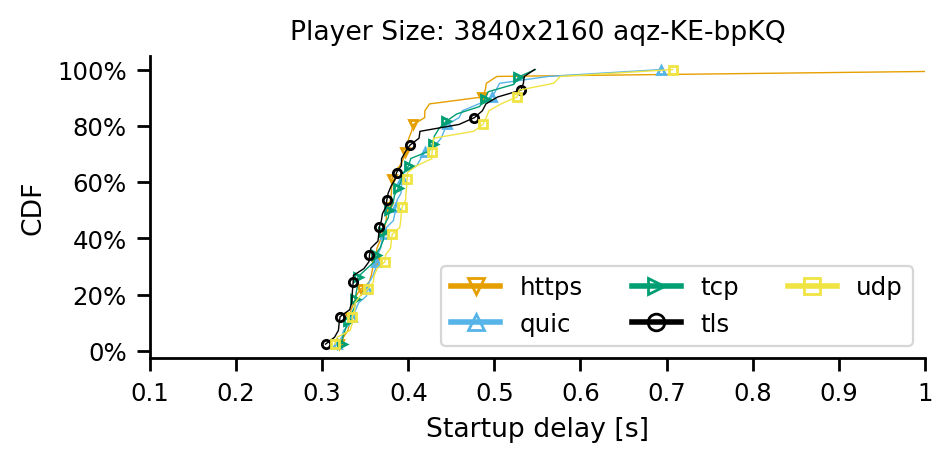

In [73]:
draw_cdf(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0.1,1])

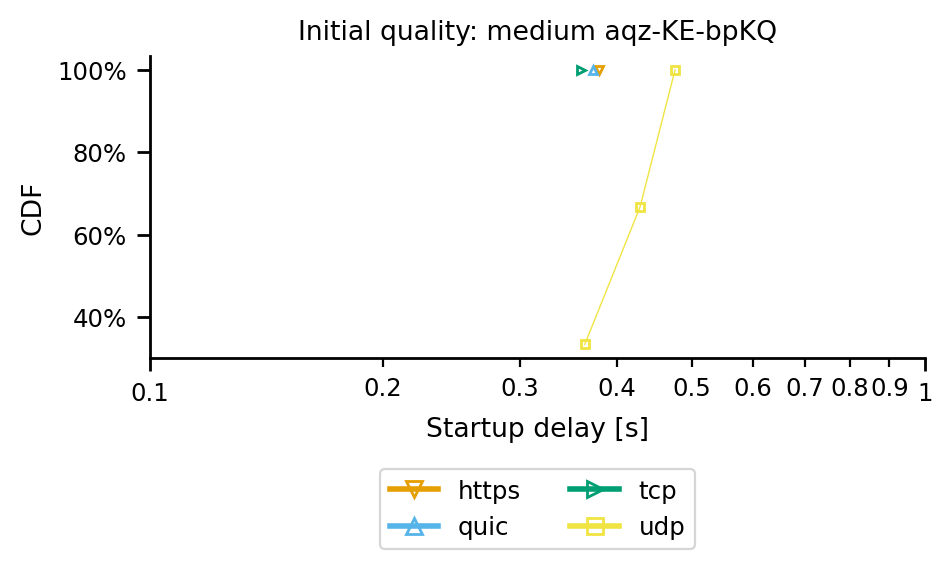

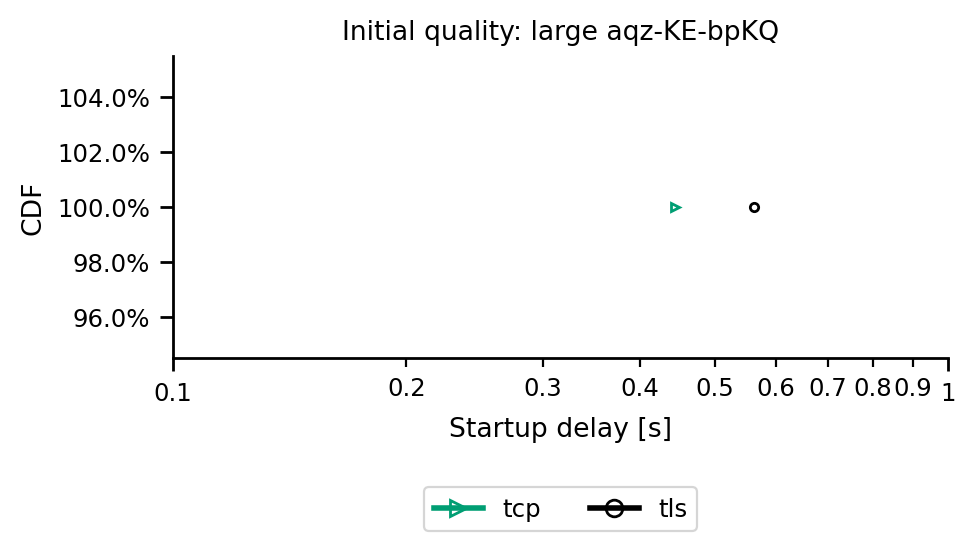

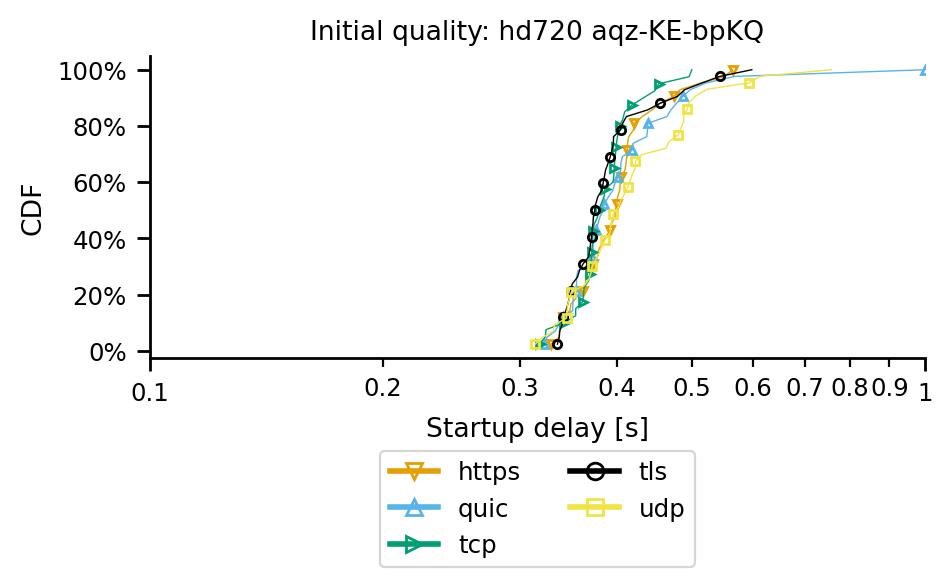

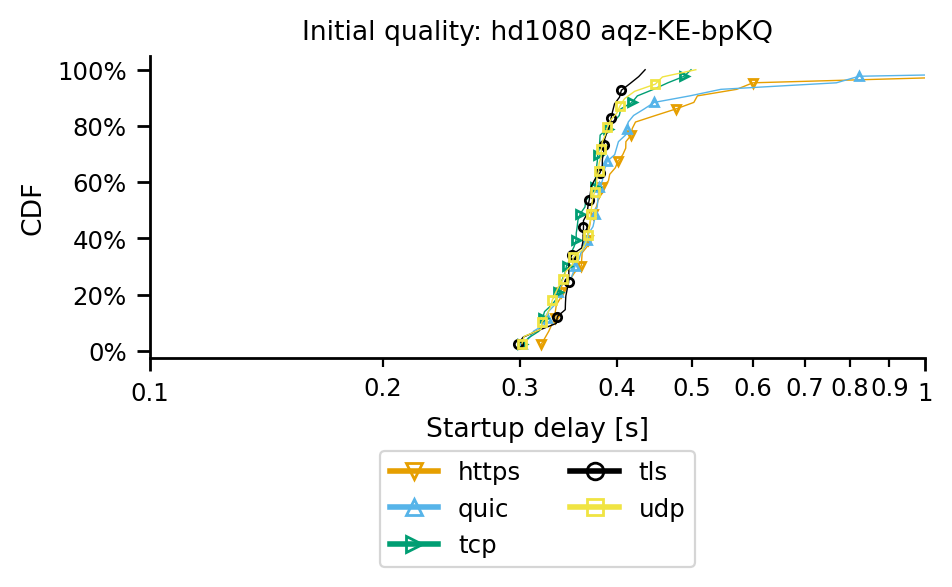

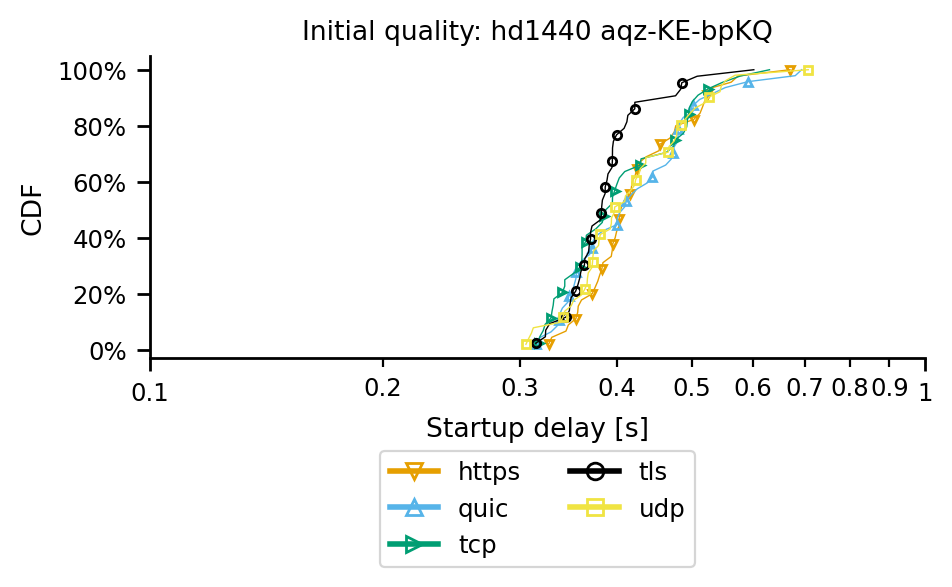

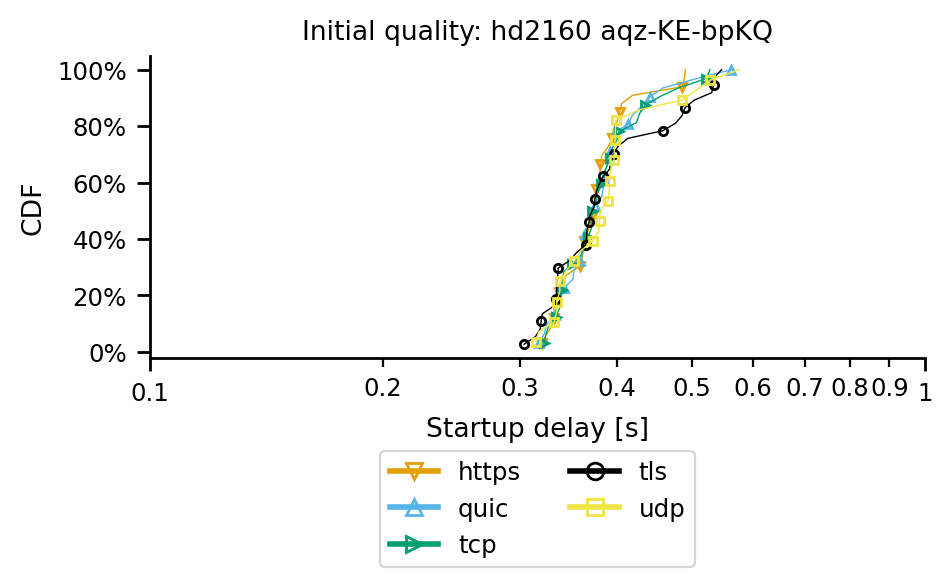

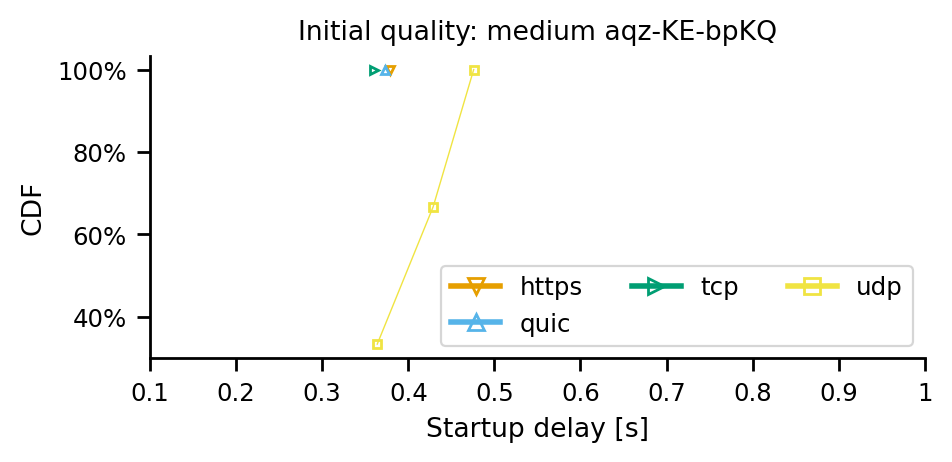

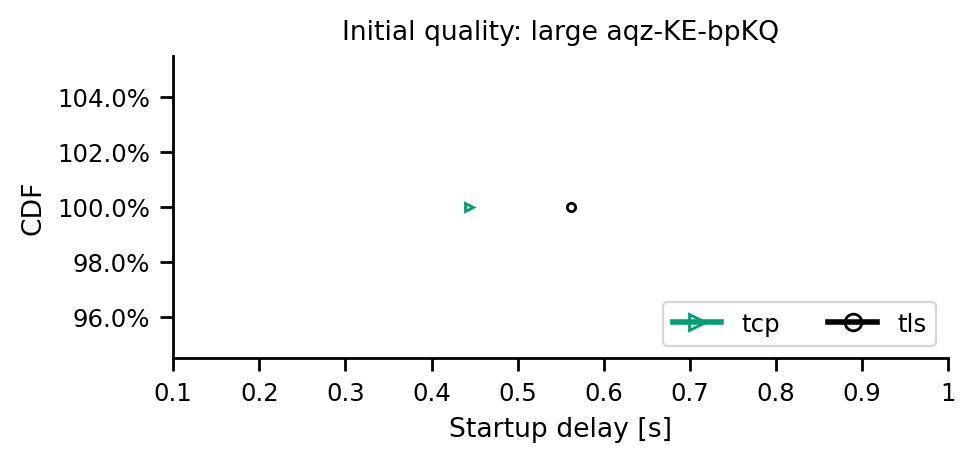

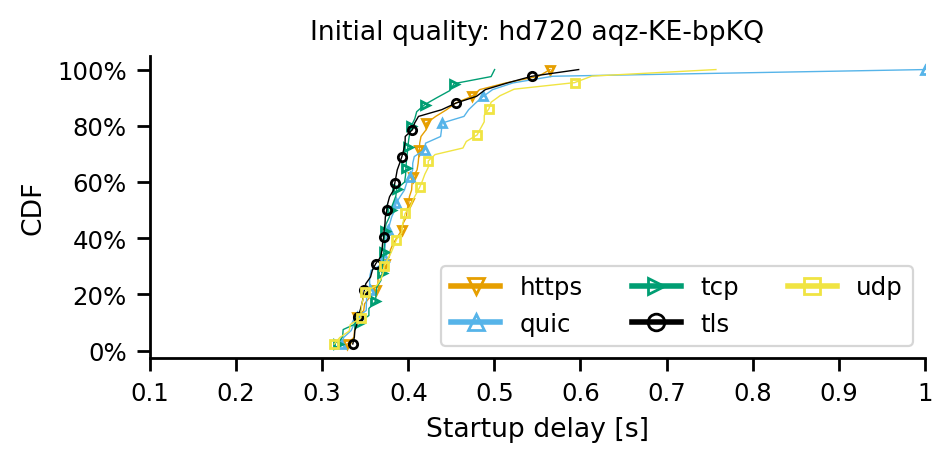

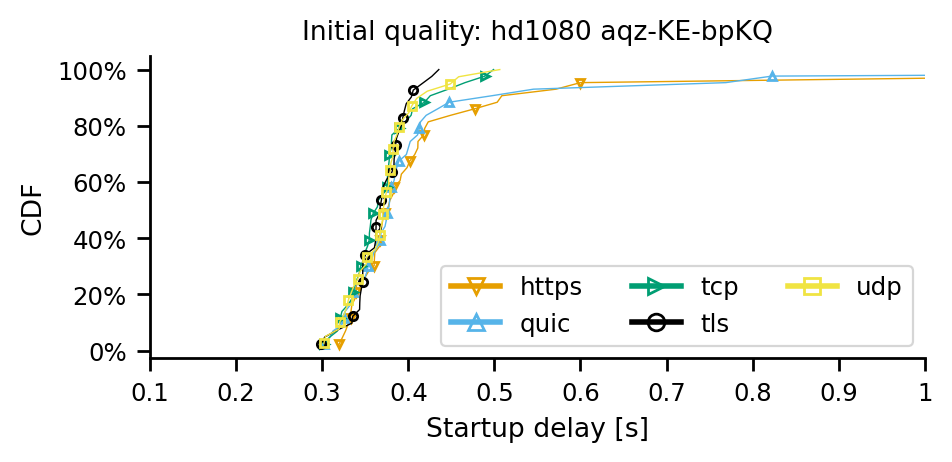

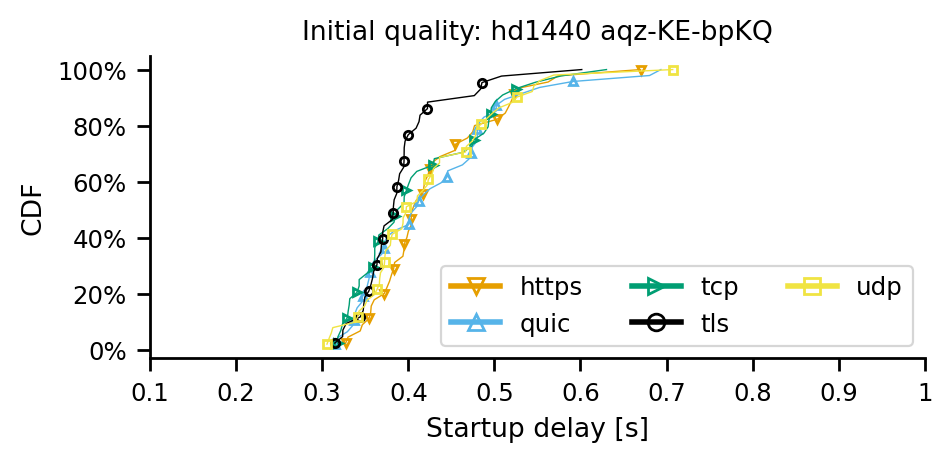

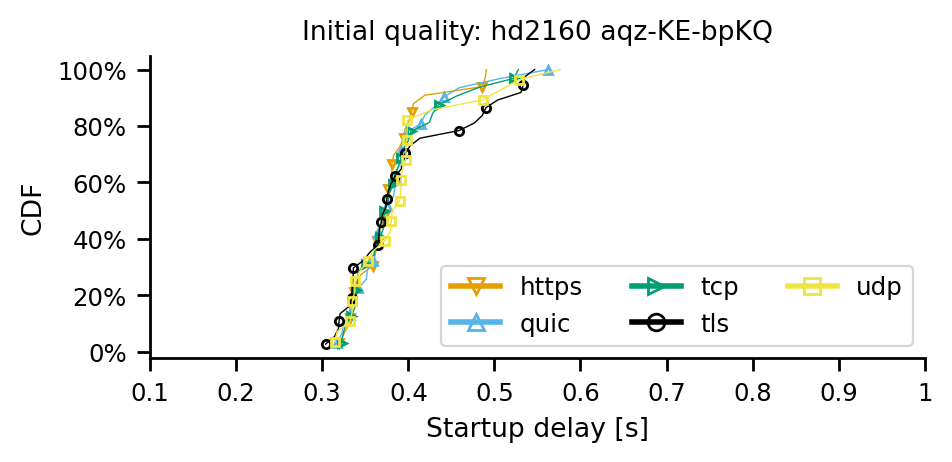

In [74]:
draw_cdf(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0.1,1])

In [77]:
def draw_boxplot(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, ylabel):
    colors = dict(zip(list(df_[col_name_].unique()), ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(list(df_[col_name_].unique()), ['o','v','^','>','s','p','h','d','<','.']))
    with plt.style.context('seaborn-whitegrid'):
        for vp in df_['vantagePoint'].unique():
            print(vp)
            for video in df_['domain'].unique():
                for log in log_list:
                    for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                        fig, ax = plt.subplots(figsize=(6,8))
                        #hue=
                        boxplt = sns.boxplot(x=col_metric_, y=col_name_ , data=df_tmp, orient='h', linewidth=1, ax=ax, 
                        showfliers=True, 
                        color='white',
                        meanline = True, showmeans = True, meanprops=dict(color='darkgoldenrod'), medianprops=dict(color='blue'))
                        sw = sns.swarmplot(x=col_metric_, y=col_name_, data=df_tmp, color=".25", ax=ax, orient='h', size=2)
                        
                        if log:
                            ax.set_xscale('log')
                        
                        
                        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                        ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


                        ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                        ax.set_xlabel(xlabel)

                        ax.set_ylabel(ylabel)
                        if xlim != [0,0]:
                            ax.set_xlim(xlim)

                        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
                        ax.grid(b=True, which='both')


                        if log:
                            fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                        else:
                            fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                        plt.show()

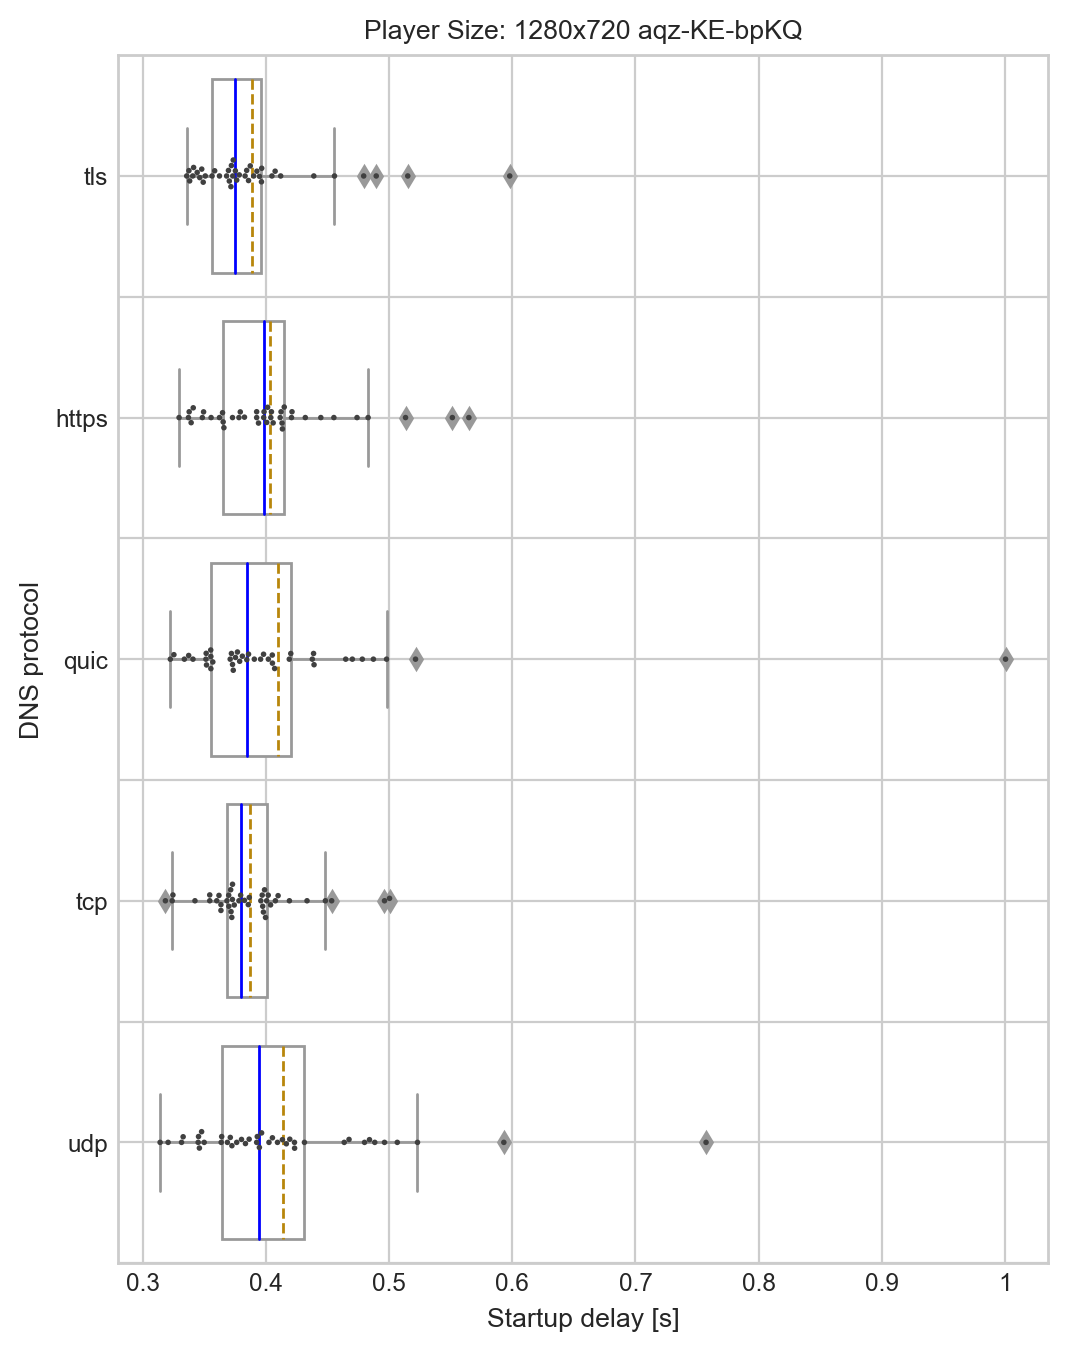

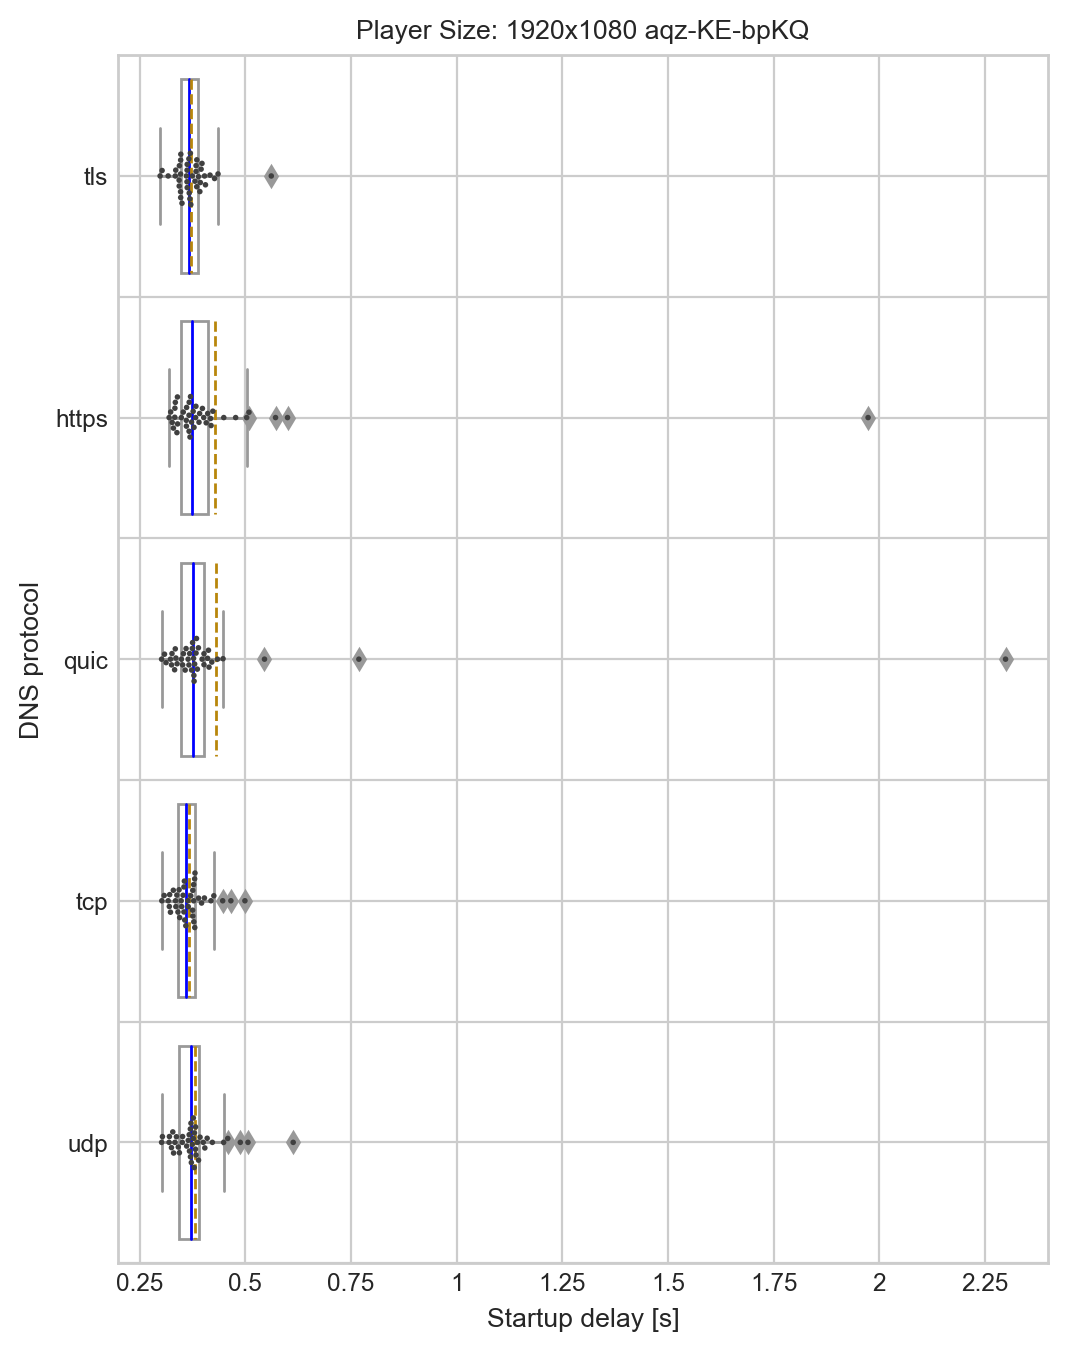

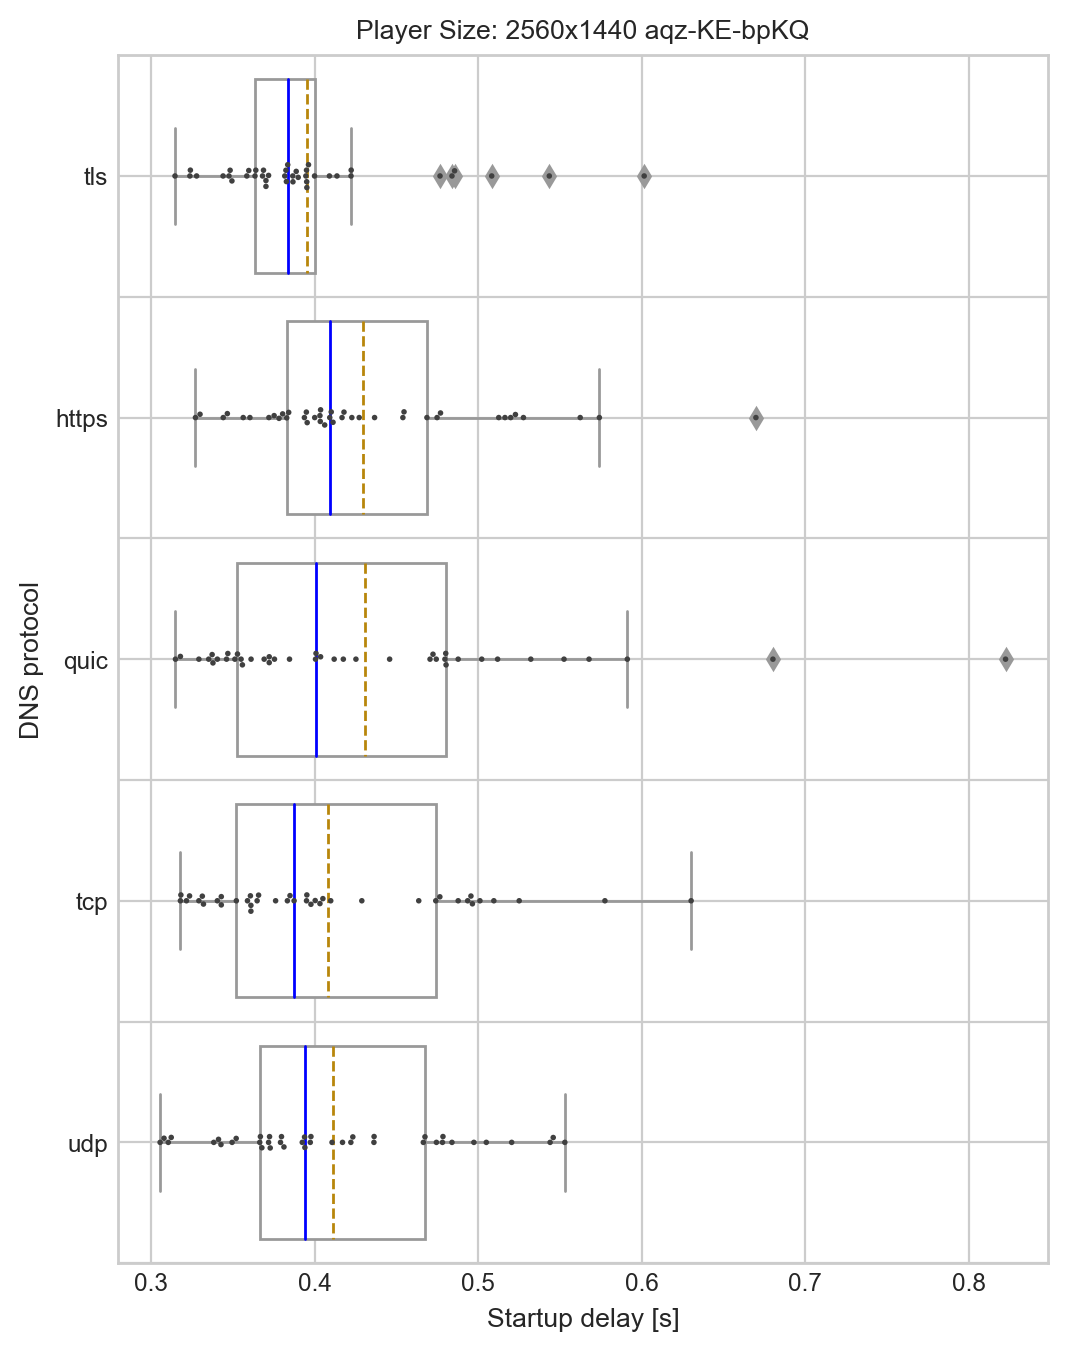

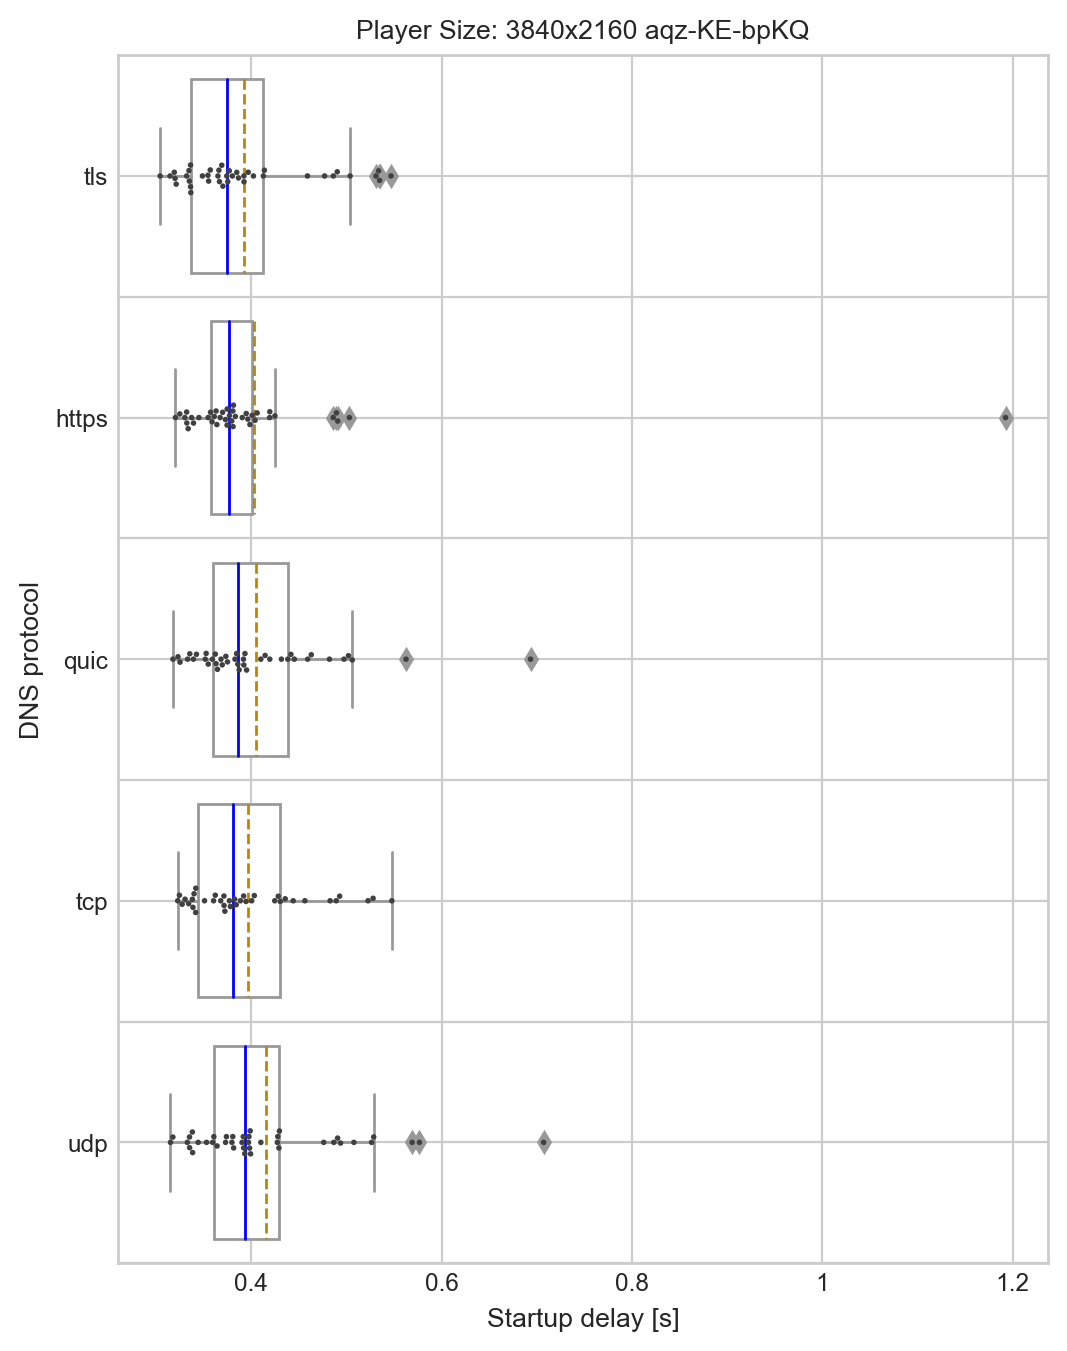

In [78]:
draw_boxplot(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0], "DNS protocol")

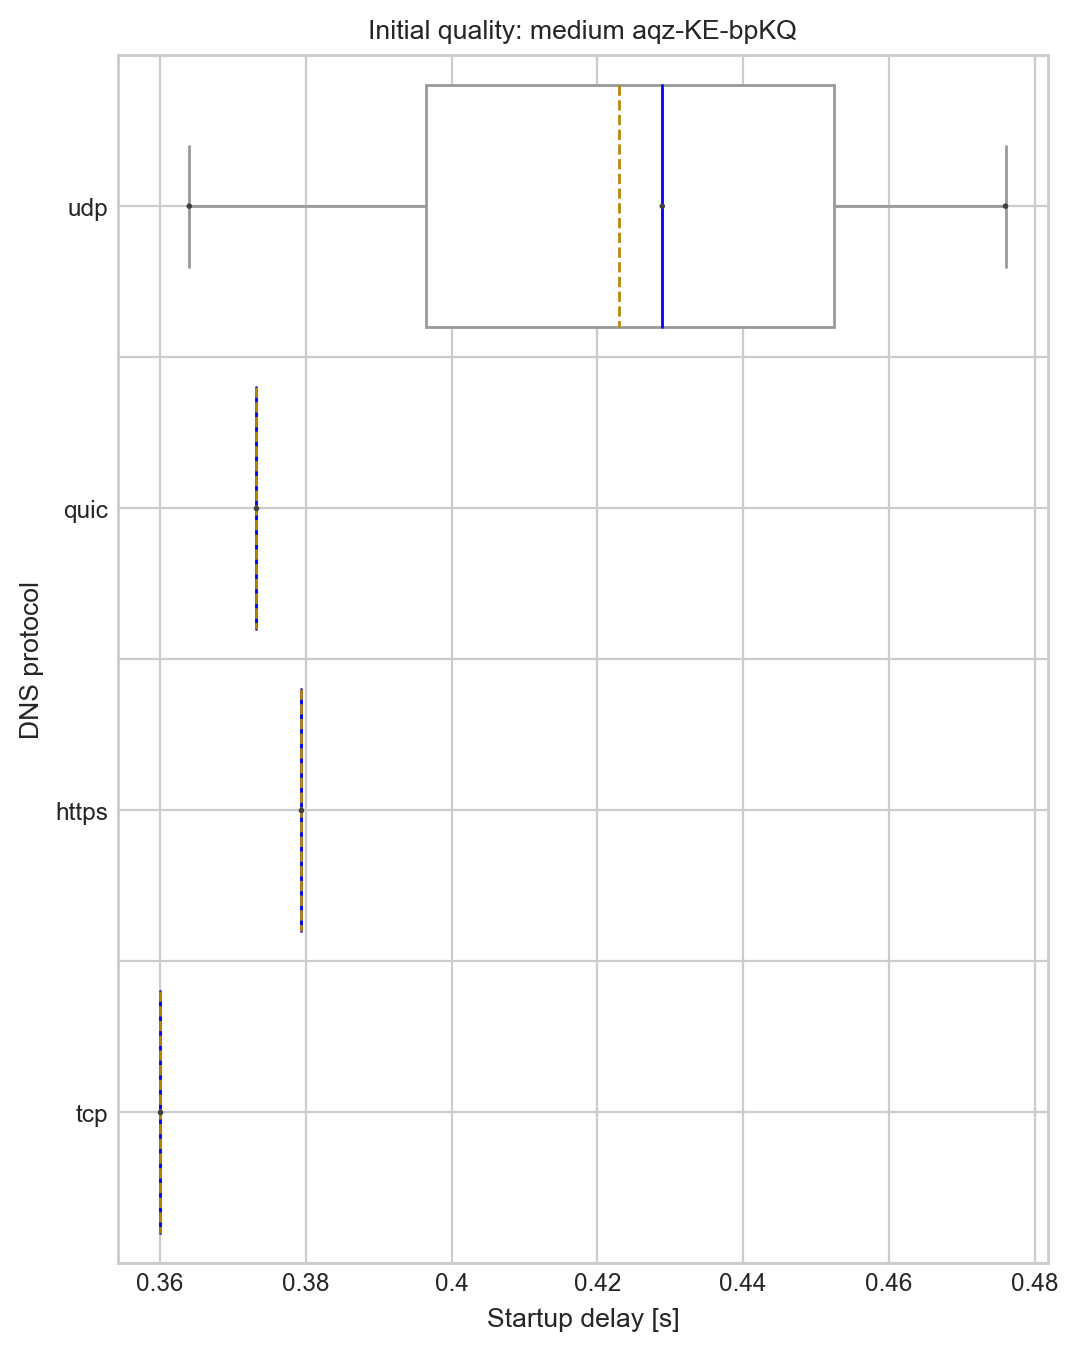

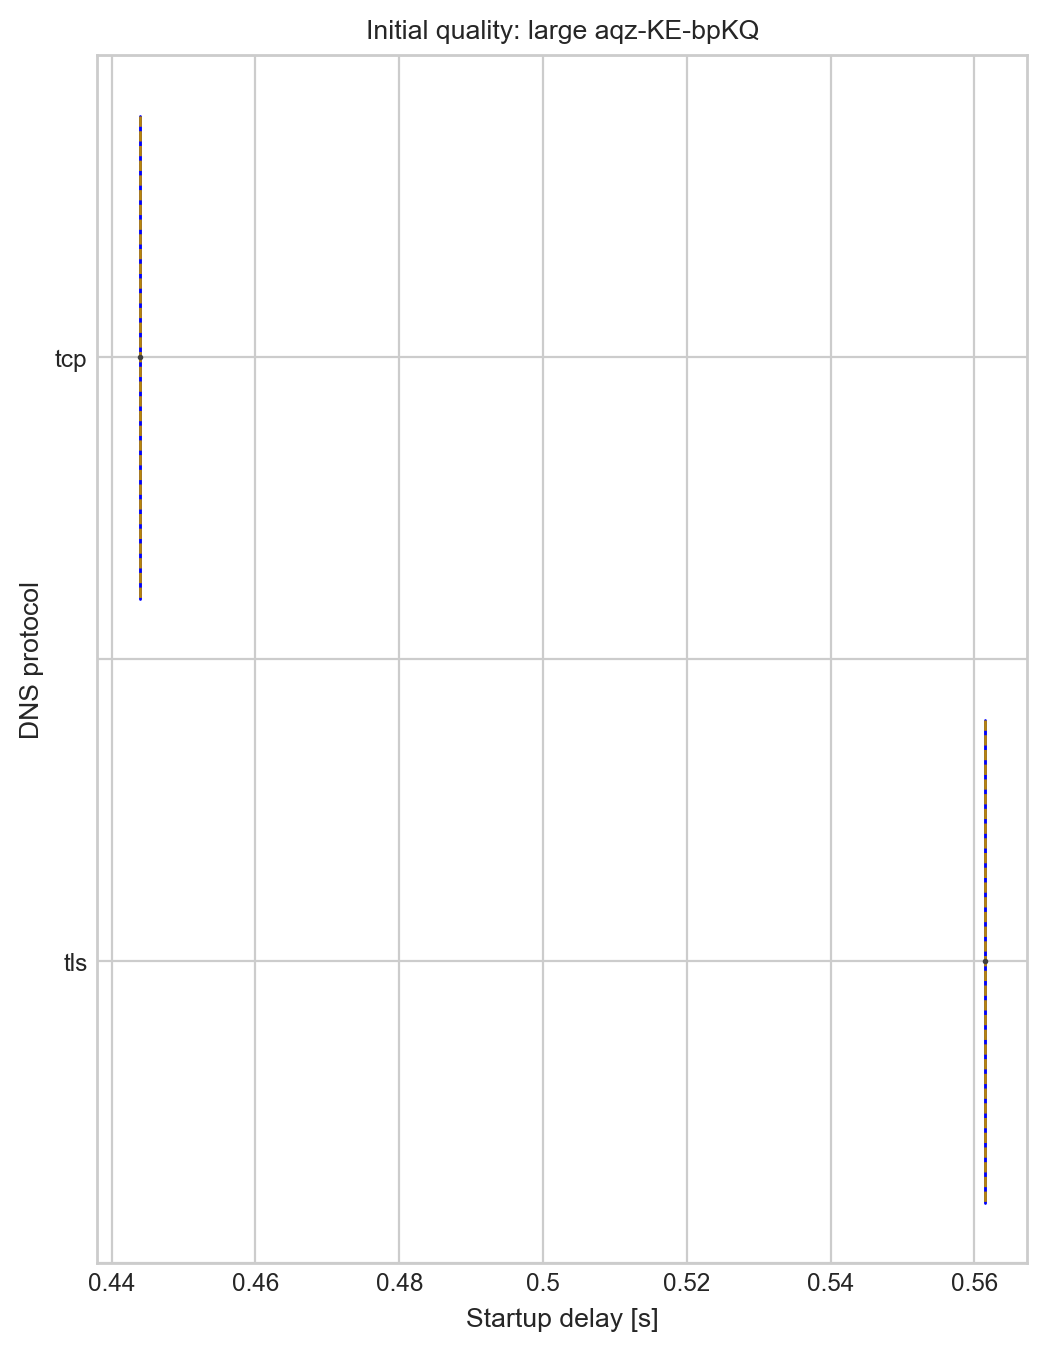

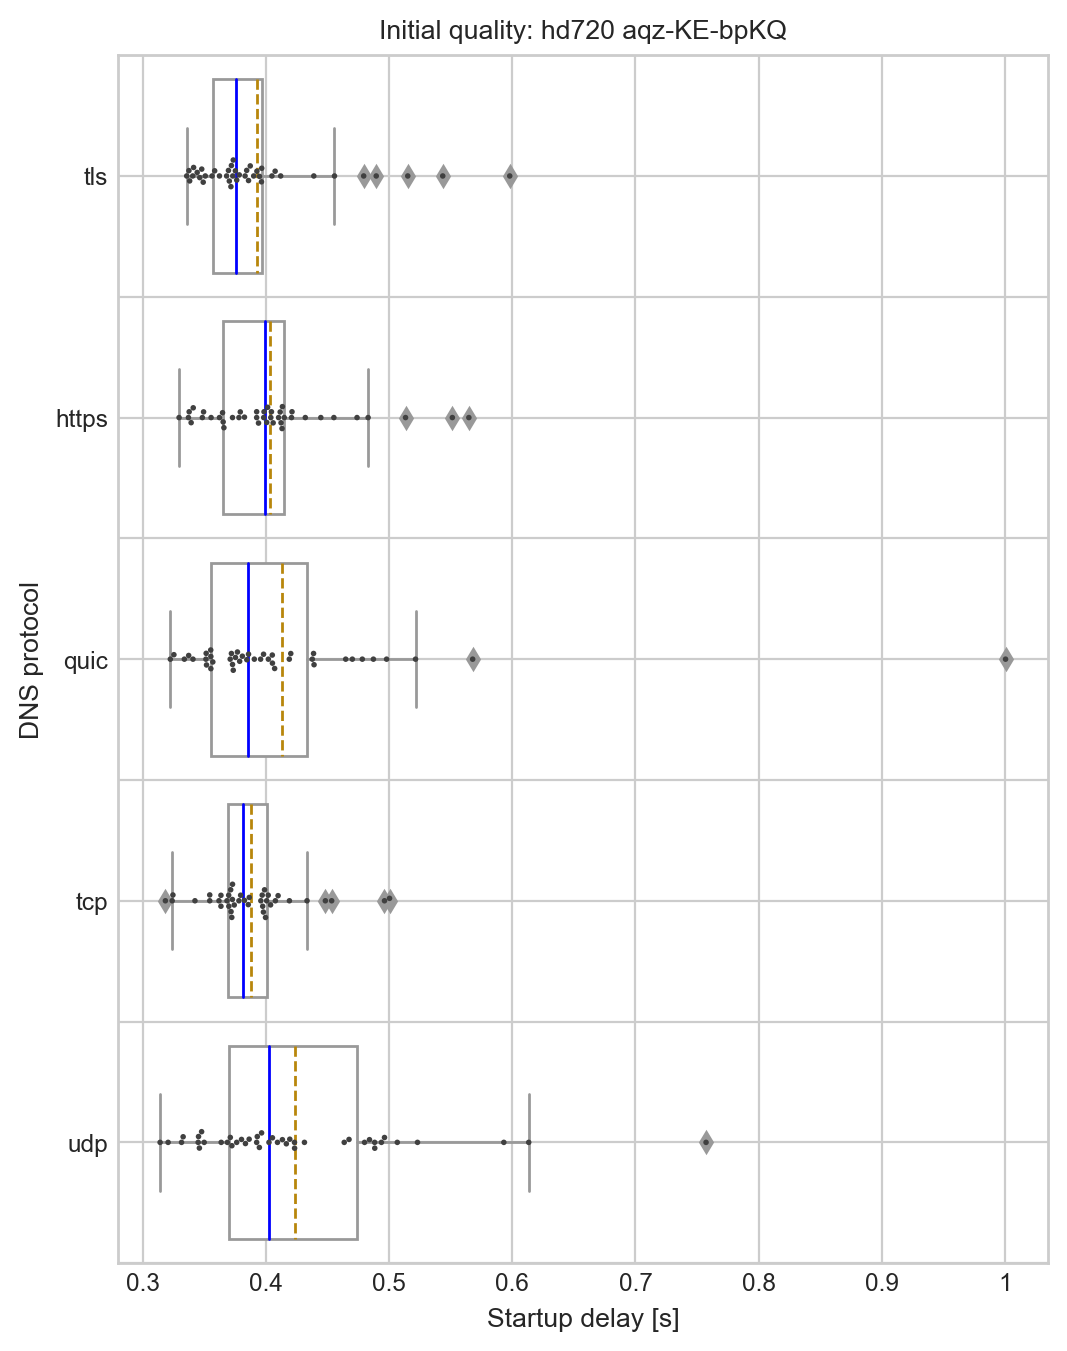

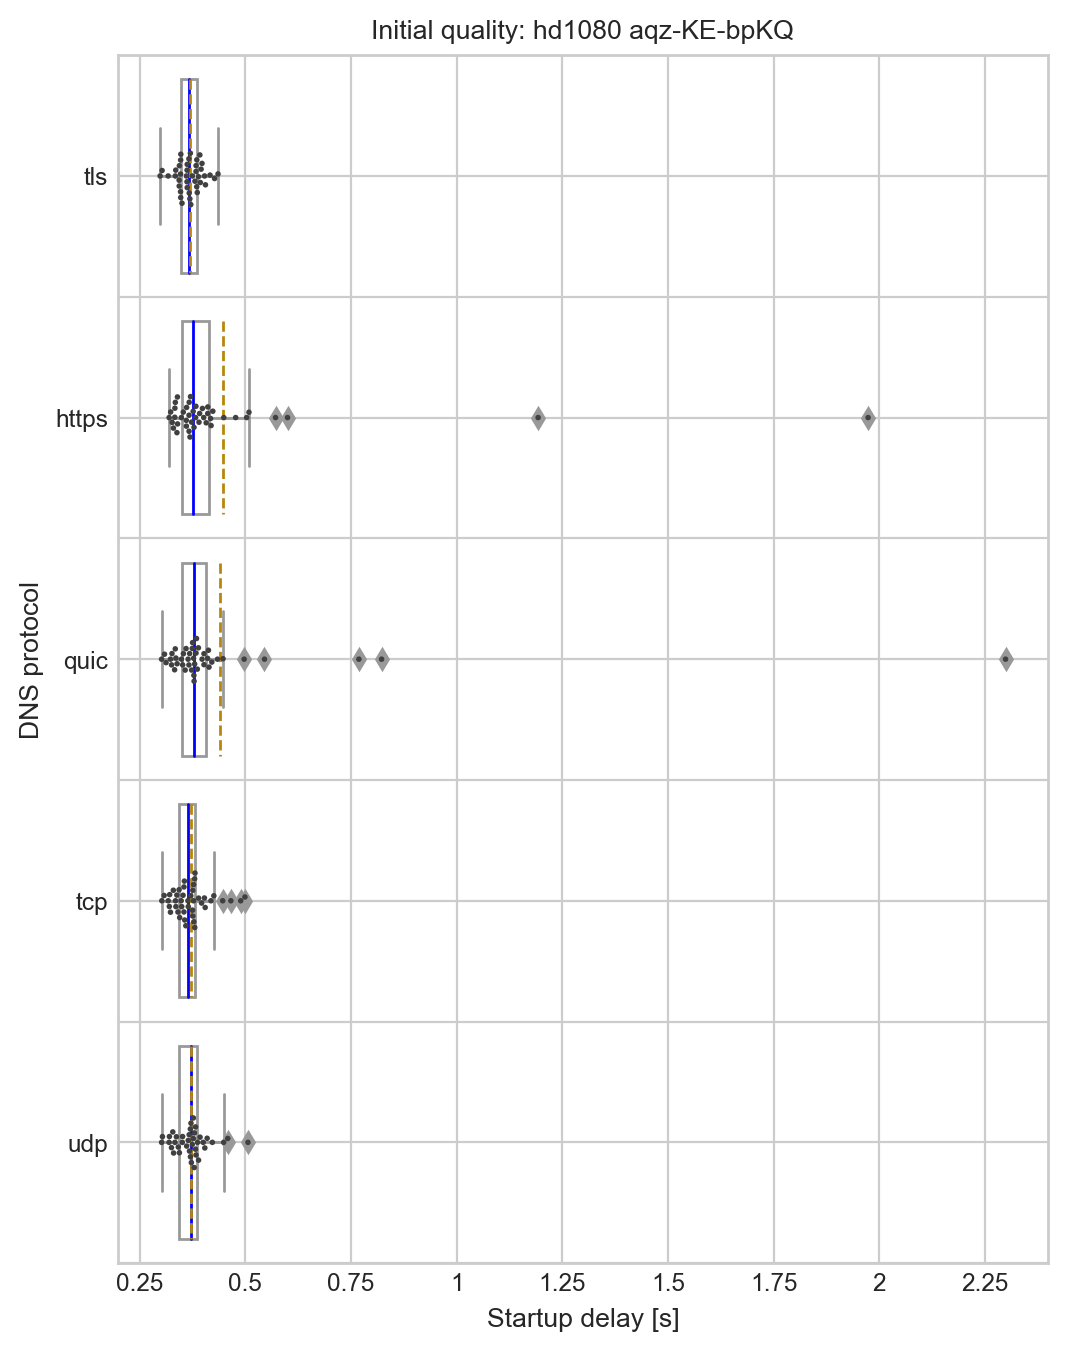

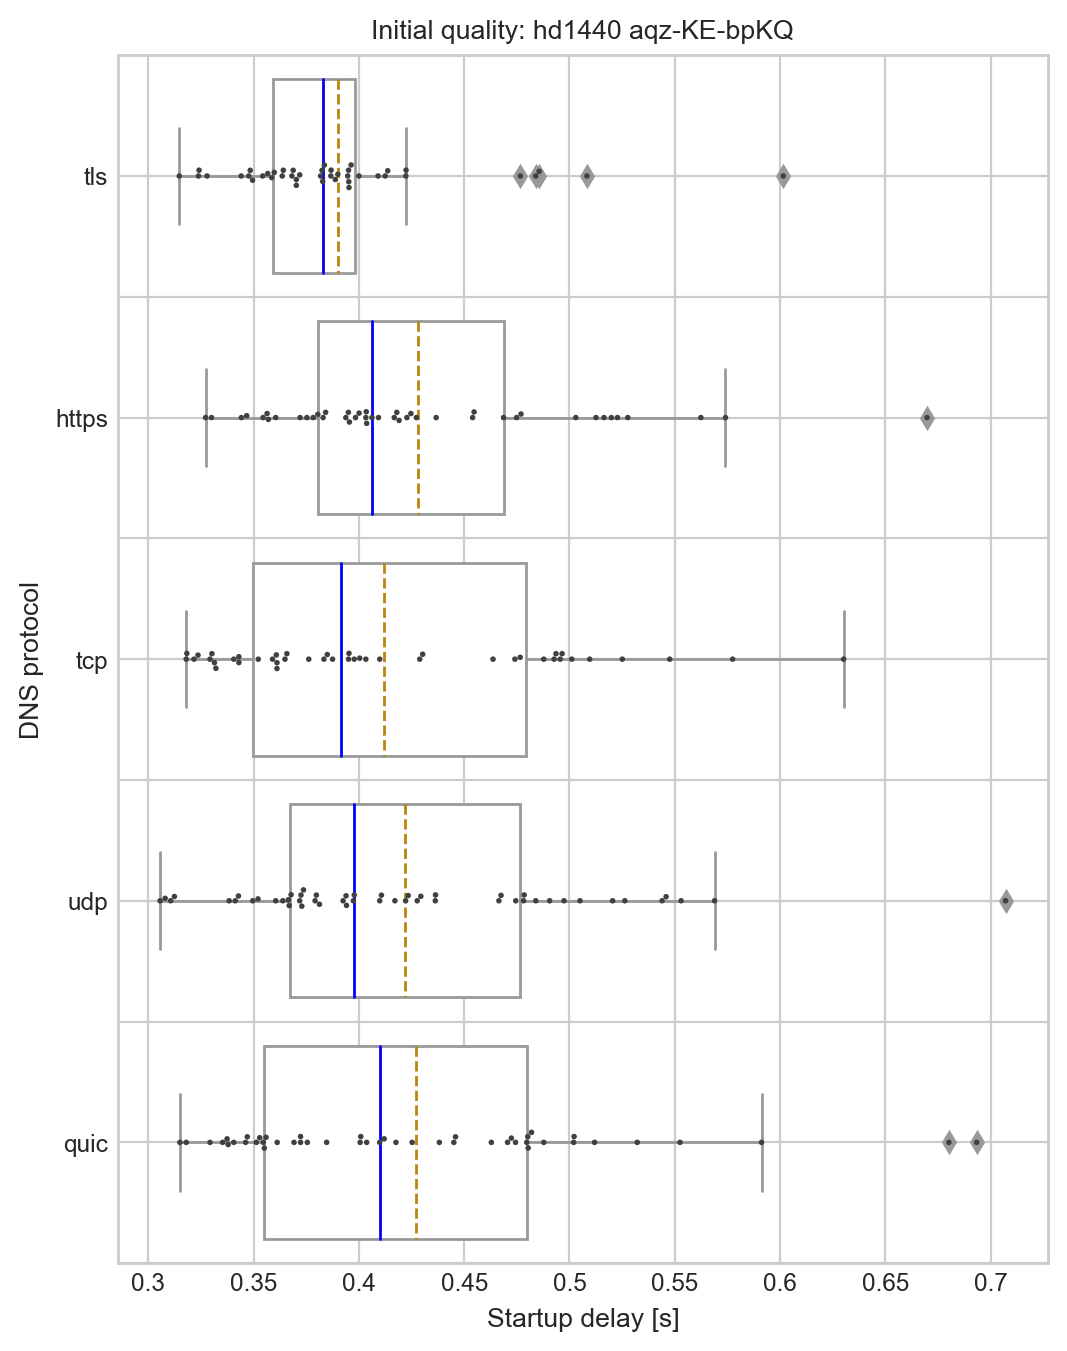

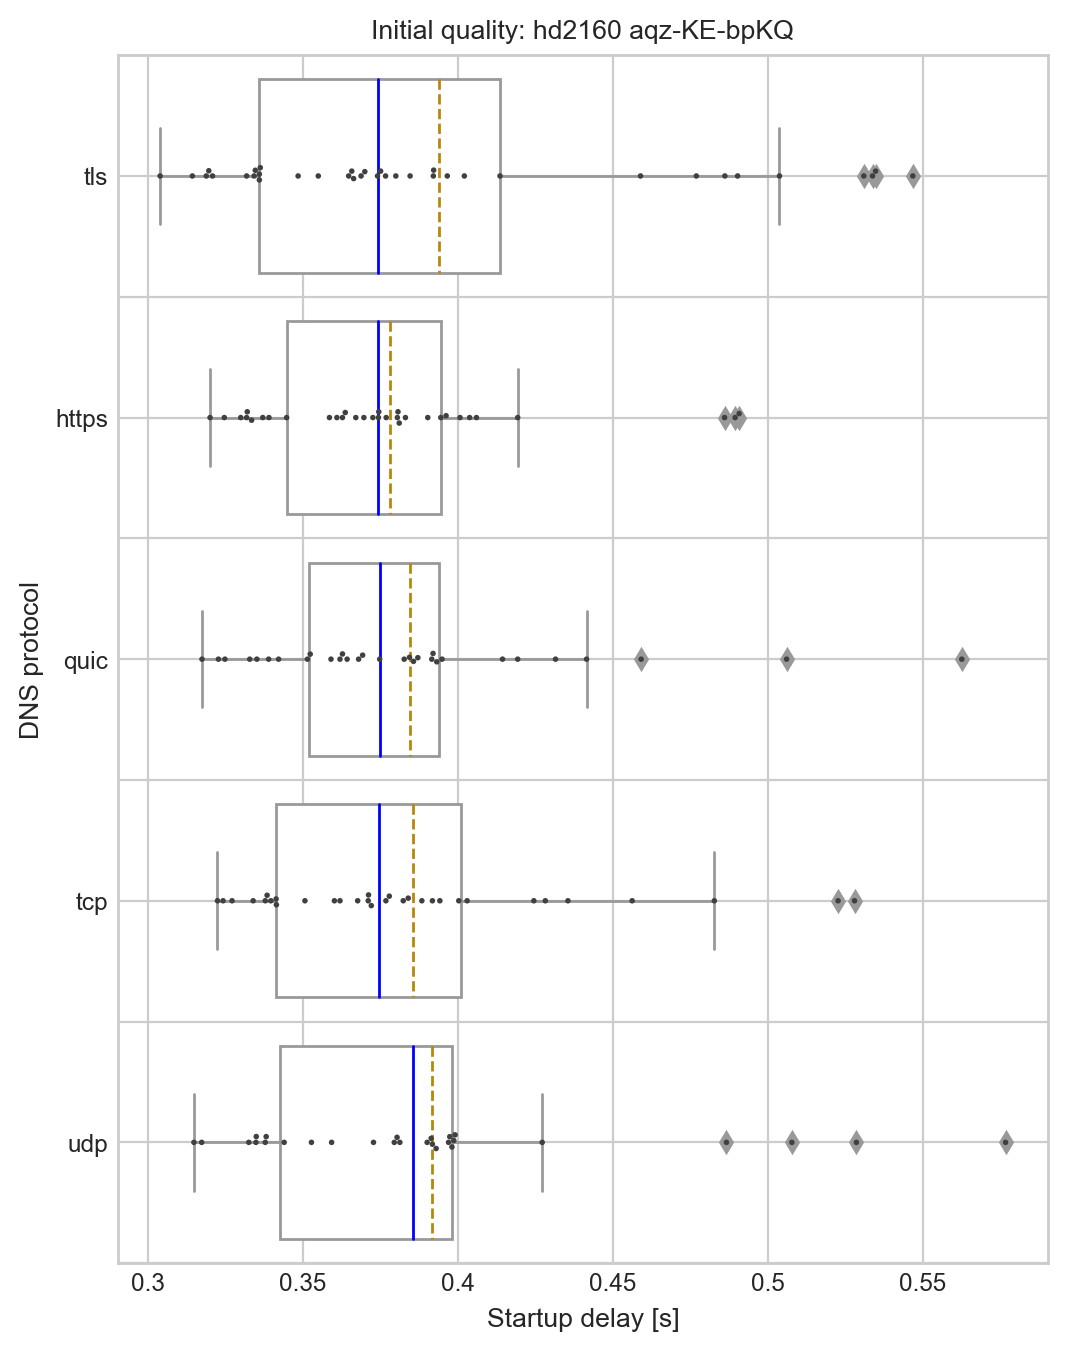

In [79]:
draw_boxplot(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0], "DNS protocol")
